In [74]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.stats import sigma_clipped_stats

from photutils.aperture import EllipticalAnnulus, CircularAperture
from photutils.isophote import EllipseGeometry, Ellipse

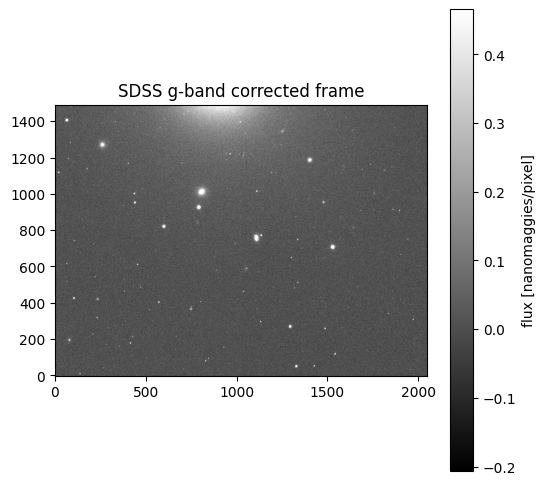

In [75]:
from astropy.visualization import ZScaleInterval, ImageNormalize  # local import for this cell only

# load data + header
img = fits.getdata("C:/Users/andre/Desktop/Astro/GalacticAstronomy/SurfaceBrightnessProfile/NGC4467.fits").astype(np.float32)
hdr = fits.getheader("C:/Users/andre/Desktop/Astro/GalacticAstronomy/SurfaceBrightnessProfile/NGC4467.fits")

# optional: pull units for labeling if available
bunit = hdr.get('BUNIT', 'flux per pixel')

# quick display with zscale
norm = ImageNormalize(img, interval=ZScaleInterval())
plt.figure(figsize=(6,6))
plt.imshow(img, origin='lower', cmap='gray', norm=norm)
plt.title("SDSS g-band corrected frame")
plt.colorbar(label='flux [nanomaggies/pixel]')
plt.show()

Global best n = 3.090, Re = 8.282", Isky = 0.1323, RMS(μ) = 0.0514 mag  (from 487 fits)

Top fits:
  1) n=3.090, Re=8.282", Isky=0.1323, Ie=1.382, RMS=0.0514 mag
  2) n=3.100, Re=8.327", Isky=0.1302, Ie=1.37, RMS=0.0514 mag
  3) n=3.075, Re=8.216", Isky=0.1355, Ie=1.399, RMS=0.0514 mag
  4) n=3.115, Re=8.394", Isky=0.1271, Ie=1.354, RMS=0.0515 mag
  5) n=3.060, Re=8.150", Isky=0.1386, Ie=1.416, RMS=0.0515 mag


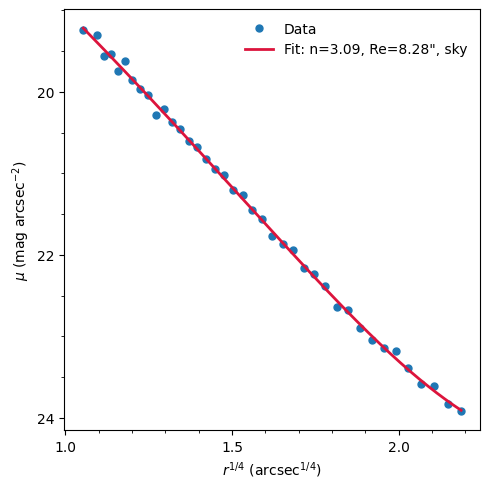

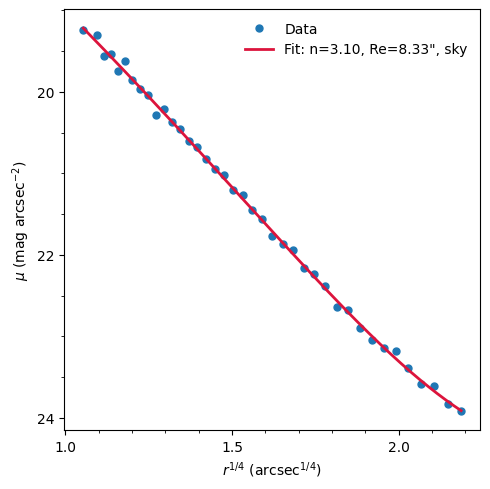

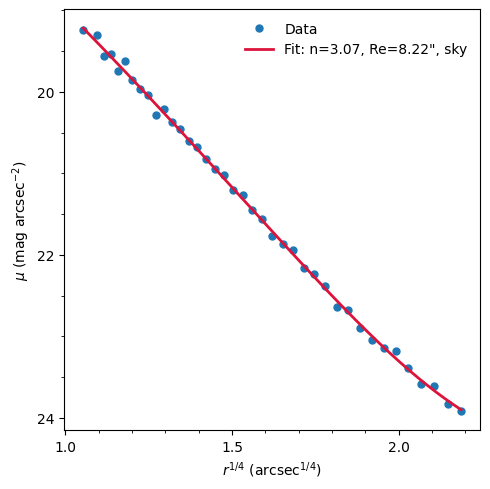

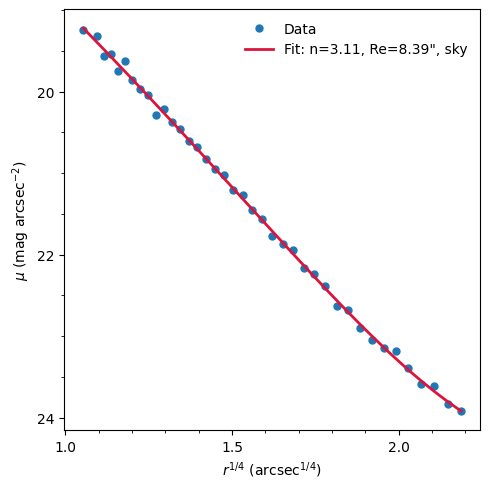

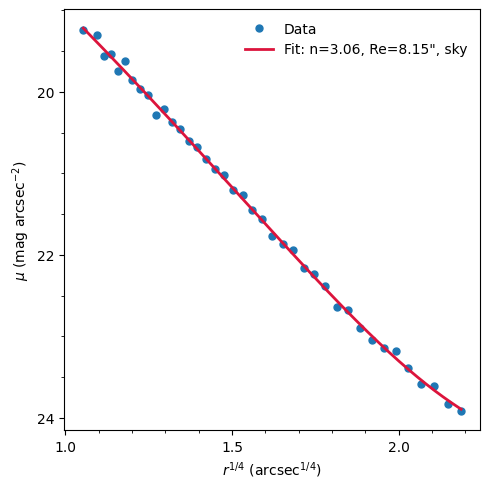

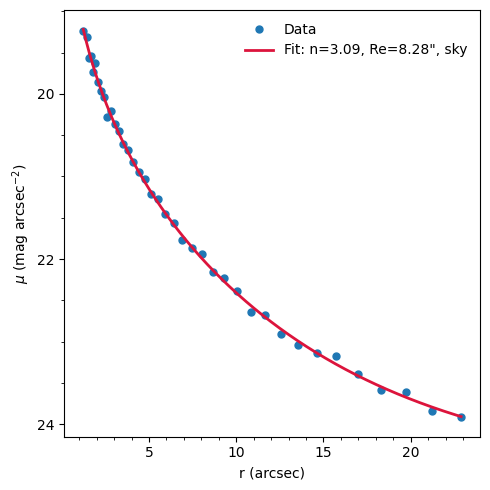

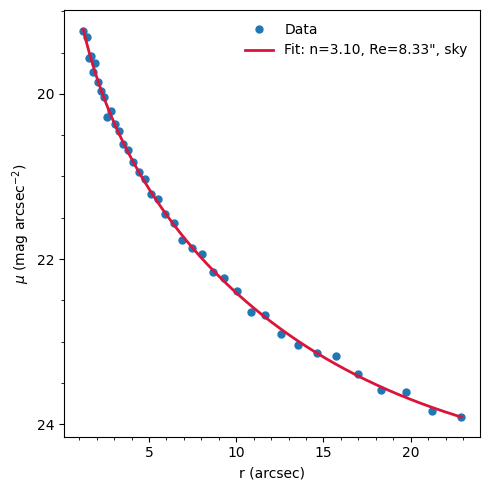

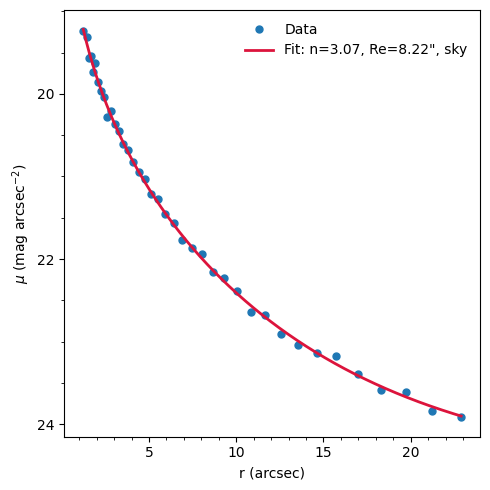

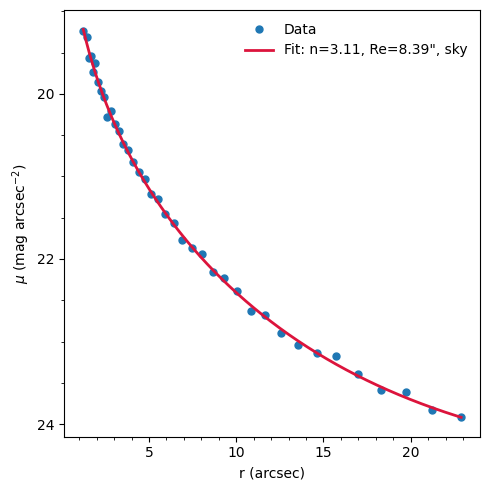

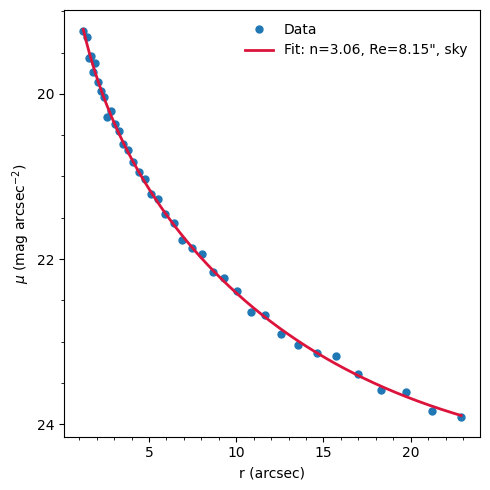


--- Sérsic Photometric Quantities ---
Best-fit n        = 3.090
Effective radius  = 8.282"  = 0.663 kpc  (D = 1.650e+07 pc)
Effective SB μ_e  = 22.149 mag/arcsec^2
Total flux F_tot  = 1897.71 (model units)
Total magnitude m_tot = 14.304 mag
Absolute magnitude M_abs = -16.783 mag
Central SB μ_0    = 15.797 mag/arcsec^2
Fitted sky I_sky  = 0.132303 (intensity units)

--- Goodness of Fit ---
RMS residual = 0.0514 mag/arcsec^2
Chi^2 (σ=0.05) = 41.23
Reduced Chi^2 = 1.18  (N=39, dof=35)


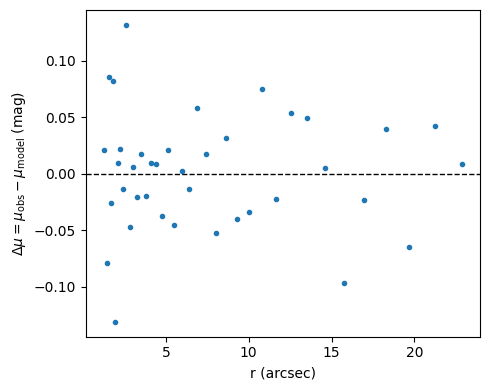

In [130]:
# --- FIXED-n Sersic scan (raw FITS; fits a sky term) ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from astropy.io import fits
from astropy.stats import sigma_clip
from photutils.aperture import EllipticalAnnulus
from scipy.optimize import curve_fit

# =========================
# USER SETTINGS
# =========================
fits_path = "C:/Users/andre/Desktop/Astro/GalacticAstronomy/SurfaceBrightnessProfile/NGC4467.fits"  # <-- non-background-subtracted image
ext = 0

# Ellipse geometry & calibration
x0, y0 = 805.0, 1012.0
q = 0.85
theta = 0.0
s = 0.396
ZP = 22.5

# Radial sampling & cleaning
nbins = 40
clip_sigma = 3.0
top_trim = 95.0
RMIN_ARCSEC = 1.2
RMAX_ARCSEC = 24.0

# n scan controls
N_COARSE_MIN, N_COARSE_MAX, N_COARSE_STEP = 0.30, 8.00, 0.02
N_FINE_HALFSPAN, N_FINE_STEP = 0.25, 0.005
TOPK = 5
ALLOW_NEGATIVE_SKY = False  # set True if you want to allow small negative sky

# =========================
# Load & build SB profile
# =========================
with fits.open(fits_path, memmap=True) as hdul:
    img = hdul[ext].data.astype(float, copy=False)

h, w = img.shape
r_min_pix = max(3, int(np.ceil(1.0 / s)))
xm = min(x0, (w - 1) - x0)
ym = min(y0, (h - 1) - y0)
r_edge_safe = int(min(xm, ym / q))
if RMAX_ARCSEC is not None:
    r_cap_pix = int(RMAX_ARCSEC / s)
    r_max_pix = min(r_edge_safe - 3, r_cap_pix)
else:
    r_max_pix = r_edge_safe - 3
r_max_pix = max(r_min_pix + 3, r_max_pix)

edges = np.geomspace(r_min_pix, r_max_pix, nbins + 1)
sma_pix = np.sqrt(edges[:-1] * edges[1:])

ints_pix = []
for a_in, a_out in zip(edges[:-1], edges[1:]):
    ann = EllipticalAnnulus((x0, y0), a_in=a_in, a_out=a_out,
                            b_in=q*a_in, b_out=q*a_out, theta=theta)
    m = ann.to_mask(method='center')
    m = m[0] if isinstance(m, list) else m
    cut = m.cutout(img)
    if cut is None:
        ints_pix.append(np.nan); continue
    vals = cut[m.data > 0]
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan); continue
    vals = sigma_clip(vals, sigma=clip_sigma, maxiters=3, masked=False)
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan); continue
    hi = np.nanpercentile(vals, top_trim)
    ints_pix.append(float(np.nanmedian(vals[vals <= hi])))

ints_pix = np.asarray(ints_pix, float)
good = np.isfinite(ints_pix) & (ints_pix > 0)
sma_pix = sma_pix[good]
ints_pix = ints_pix[good]

r_arcsec = sma_pix * s
I_as2 = ints_pix / (s**2)
mu = ZP - 2.5 * np.log10(I_as2)

m = np.isfinite(r_arcsec) & np.isfinite(mu)
if RMIN_ARCSEC is not None: m &= (r_arcsec >= RMIN_ARCSEC)
if RMAX_ARCSEC is not None: m &= (r_arcsec <= RMAX_ARCSEC)
r = r_arcsec[m].astype(float)
mu_arr = mu[m].astype(float)
I_data = 10**((ZP - mu_arr) / 2.5)  # includes sky

# =========================
# Fixed-n scan with sky term
# =========================
def b_n(n):
    return 2*n - 1.0/3.0 + 4.0/(405.0*n) + 46.0/(25515.0*n**2)

def sersic_I_fixedn_sky(r, Ie, Re, Isky, n):
    return Ie * np.exp(-b_n(n) * ((r / Re)**(1.0/n) - 1.0)) + Isky

def mu_from_I(I):
    I = np.clip(I, 1e-300, None)
    return ZP - 2.5*np.log10(I)

Re_bounds = (0.05, max(0.06, 1.2*np.max(r)))
Ie_bounds = (1e-12, np.inf)
if ALLOW_NEGATIVE_SKY:
    SKY_bounds = (-np.inf, np.inf)
else:
    SKY_bounds = (0.0, np.inf)

def fit_fixed_n(nval):
    Ie0 = np.percentile(I_data, 85.0)
    Re0 = max(0.05, 0.25*np.max(r))
    Isky0 = max(0.0, np.percentile(I_data, 5.0))  # crude low percentile as start
    p0 = [Ie0, Re0, Isky0]
    bounds = ([Ie_bounds[0], Re_bounds[0], SKY_bounds[0]],
              [Ie_bounds[1], Re_bounds[1], SKY_bounds[1]])
    try:
        popt, _ = curve_fit(lambda rr, Ie, Re, Isky: sersic_I_fixedn_sky(rr, Ie, Re, Isky, nval),
                            r, I_data, p0=p0, bounds=bounds, maxfev=30000)
        Ie, Re, Isky = popt
        mu_model = mu_from_I(sersic_I_fixedn_sky(r, Ie, Re, Isky, nval))
        rms = float(np.sqrt(np.nanmean((mu_arr - mu_model)**2)))
        return dict(n=nval, Ie=Ie, Re=Re, Isky=Isky, rms=rms)
    except Exception:
        return None

# coarse scan
n_grid_coarse = np.arange(N_COARSE_MIN, N_COARSE_MAX + 1e-9, N_COARSE_STEP)
cands = []
for nv in n_grid_coarse:
    out = fit_fixed_n(nv)
    if out is not None and np.isfinite(out['rms']):
        cands.append(out)
best_coarse = min(cands, key=lambda d: d['rms'])

# fine scan
n_best = best_coarse['n']
n_grid_fine = np.arange(max(N_COARSE_MIN, n_best - N_FINE_HALFSPAN),
                        min(N_COARSE_MAX, n_best + N_FINE_HALFSPAN) + 1e-9,
                        N_FINE_STEP)
for nv in n_grid_fine:
    out = fit_fixed_n(nv)
    if out is not None and np.isfinite(out['rms']):
        cands.append(out)

# rank & pick
cands.sort(key=lambda d: d['rms'])
best = []
for c in cands:
    if not any(abs(c['n'] - b['n']) < 0.01 for b in best):
        best.append(c)
bestk = best[:TOPK]
best_global = bestk[0]

print(f"Global best n = {best_global['n']:.3f}, Re = {best_global['Re']:.3f}\", "
      f"Isky = {best_global['Isky']:.4g}, RMS(μ) = {best_global['rms']:.4f} mag  (from {len(cands)} fits)")
print("\nTop fits:")
for i, f in enumerate(bestk, 1):
    print(f" {i:>2d}) n={f['n']:.3f}, Re={f['Re']:.3f}\", Isky={f['Isky']:.4g}, "
          f"Ie={f['Ie']:.4g}, RMS={f['rms']:.4f} mag")

# =========================
# Plotting (five in r^{1/4}, five in r)
# =========================
def style_axes(ax, xmode):
    ax.yaxis.set_major_locator(MultipleLocator(2.0))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.invert_yaxis()
    if xmode == 'r14':
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))
        ax.set_xlabel(r'$r^{1/4}$ (arcsec$^{1/4}$)')
    else:
        ax.xaxis.set_major_locator(MultipleLocator(5.0))
        ax.xaxis.set_minor_locator(MultipleLocator(1.0))
        ax.set_xlabel('r (arcsec)')
    ax.set_ylabel(r'$\mu$ (mag arcsec$^{-2}$)')

xx = np.linspace(r.min(), r.max(), 800)
xx14 = xx**0.25
r14 = r**0.25

# r^{1/4}
for f in bestk:
    Ie, Re, Isky, n = f['Ie'], f['Re'], f['Isky'], f['n']
    I_fit = sersic_I_fixedn_sky(xx, Ie, Re, Isky, n)
    mu_fit = mu_from_I(I_fit)
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(r14, mu_arr, '.', ms=10, label='Data')
    ax.plot(xx14, mu_fit, '-', lw=2.0, color='crimson',
            label=f"Fit: n={n:.2f}, Re={Re:.2f}\", sky")
    
    style_axes(ax, 'r14')
    # ax.set_title('Sérsic + sky fits (raw image)')
    ax.legend(frameon=False)
    plt.tight_layout(); plt.show()

# r
for f in bestk:
    Ie, Re, Isky, n = f['Ie'], f['Re'], f['Isky'], f['n']
    I_fit = sersic_I_fixedn_sky(xx, Ie, Re, Isky, n)
    mu_fit = mu_from_I(I_fit)
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(r, mu_arr, '.', ms=10, label='Data')
    ax.plot(xx, mu_fit, '-', lw=2.0, color='crimson',
            label=f"Fit: n={n:.2f}, Re={Re:.2f}\", sky")
    style_axes(ax, 'r')
    # ax.set_title('Sérsic + sky fits (raw image)')
    ax.legend(frameon=False)
    plt.tight_layout(); plt.show()
    
from scipy.special import gamma  # for Γ(2n)

# --- user distance in parsecs ---
D_pc = 1.65e7   # 16.5 Mpc; adjust as needed

# --- helper ---
def b_n(n):
    return 2*n - 1.0/3.0 + 4.0/(405.0*n) + 46.0/(25515.0*n**2)

def mu_from_I(I):
    I = np.clip(I, 1e-300, None)
    return ZP - 2.5*np.log10(I)

# --- extract best fit ---
n = best_global['n']
Re = best_global['Re']
Ie = best_global['Ie']

# if your fit included a sky term (raw FITS case), subtract it off:
Isky = best_global.get('Isky', 0.0)

# effective SB at Re
mu_e = mu_from_I(Ie)

# Re in kpc
arcsec_to_pc = D_pc * (np.pi / (180.0 * 3600.0))
Re_kpc = Re * arcsec_to_pc / 1e3

# total flux (model only, no sky)
bn = b_n(n)
F_tot = 2.0 * np.pi * Ie * (Re**2) * n * np.exp(bn) * (bn**(-2.0*n)) * gamma(2.0*n)

# apparent total magnitude
m_tot = ZP - 2.5*np.log10(F_tot)

# absolute magnitude
M_abs = m_tot - 5.0 * np.log10(D_pc / 10.0)

# central surface brightness
I0 = Ie * np.exp(bn)
mu0 = mu_from_I(I0)

print("\n--- Sérsic Photometric Quantities ---")
print(f"Best-fit n        = {n:.3f}")
print(f"Effective radius  = {Re:.3f}\"  = {Re_kpc:.3f} kpc  (D = {D_pc:.3e} pc)")
print(f"Effective SB μ_e  = {mu_e:.3f} mag/arcsec^2")
print(f"Total flux F_tot  = {F_tot:.6g} (model units)")
print(f"Total magnitude m_tot = {m_tot:.3f} mag")
print(f"Absolute magnitude M_abs = {M_abs:.3f} mag")
print(f"Central SB μ_0    = {mu0:.3f} mag/arcsec^2")
if Isky > 0:
    print(f"Fitted sky I_sky  = {Isky:.6g} (intensity units)")
    


# --- Goodness of fit diagnostics ---

from scipy.special import gamma  # needed if not already imported

def b_n(n):
    return 2*n - 1.0/3.0 + 4.0/(405.0*n) + 46.0/(25515.0*n**2)

def sersic_I(r, Ie, Re, n, Isky=0.0):
    return Ie * np.exp(-b_n(n) * ((r / Re)**(1.0/n) - 1.0)) + Isky

def mu_from_I(I):
    I = np.clip(I, 1e-300, None)
    return ZP - 2.5*np.log10(I)

# extract best-fit parameters
Ie   = best_global['Ie']
Re   = best_global['Re']
n    = best_global['n']
Isky = best_global.get('Isky', 0.0)

# model μ profile at fitted radii
mu_model = mu_from_I(sersic_I(r, Ie, Re, n, Isky))

# residuals
resid = mu_arr - mu_model

# --- RMS of residuals ---
rms = np.sqrt(np.nanmean(resid**2))

# --- Chi-square diagnostics ---
# If you don’t have real uncertainties, assume a uniform σ (e.g. 0.05 mag/arcsec^2).
sigma_assumed = 0.05
chi2 = np.sum((resid / sigma_assumed)**2)
ndof = len(resid) - (4 if 'Isky' in best_global else 3)  # free params: Ie, Re, n, (Isky optional)
chi2_red = chi2 / ndof

print("\n--- Goodness of Fit ---")
print(f"RMS residual = {rms:.4f} mag/arcsec^2")
print(f"Chi^2 (σ={sigma_assumed:.2f}) = {chi2:.2f}")
print(f"Reduced Chi^2 = {chi2_red:.2f}  (N={len(resid)}, dof={ndof})")

# --- Residual plot ---
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,4))
ax.axhline(0, color='k', ls='--', lw=1)
ax.plot(r, resid, 'o', ms=3)
ax.set_xlabel('r (arcsec)')
ax.set_ylabel(r'$\Delta \mu = \mu_{\mathrm{obs}} - \mu_{\mathrm{model}}$ (mag)')
# ax.set_title('Residuals of best Sérsic fit')
plt.tight_layout(); plt.show()



Global best n = 1.895, Re = 4.672"  RMS(μ) = 0.3309 mag  (from 487 fits)

Top fits:
  1) n=1.895, Re=4.672"  Ie=3.435  RMS=0.3309 mag
  2) n=1.910, Re=4.701"  Ie=3.399  RMS=0.3310 mag
  3) n=1.880, Re=4.642"  Ie=3.472  RMS=0.3311 mag
  4) n=1.920, Re=4.721"  Ie=3.375  RMS=0.3312 mag
  5) n=1.870, Re=4.623"  Ie=3.497  RMS=0.3314 mag


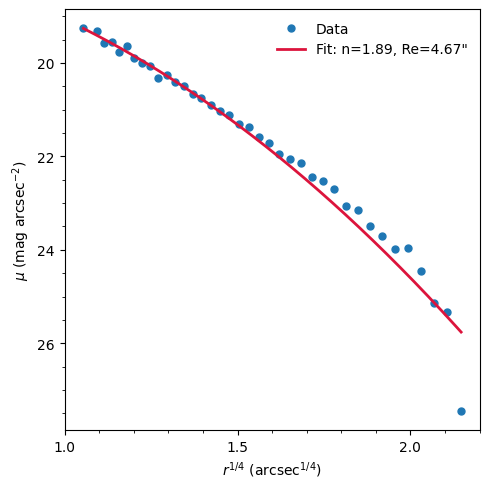

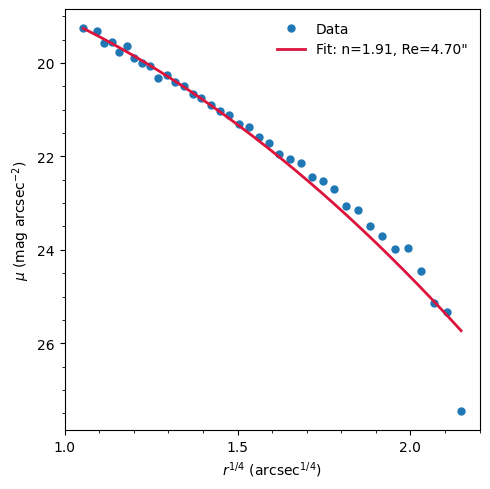

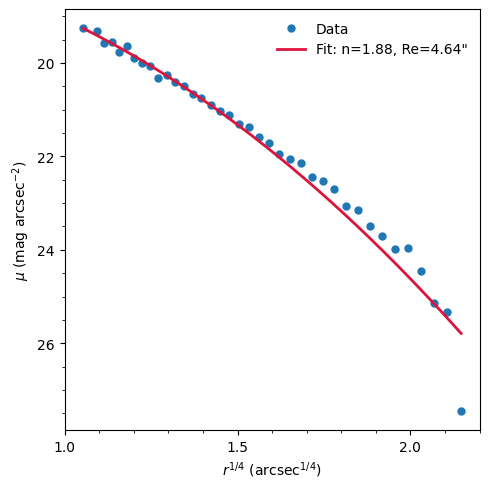

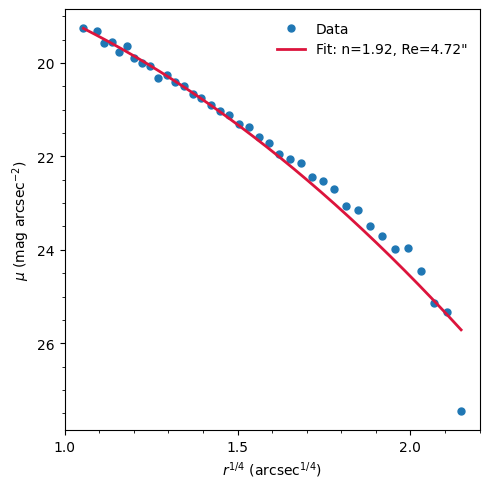

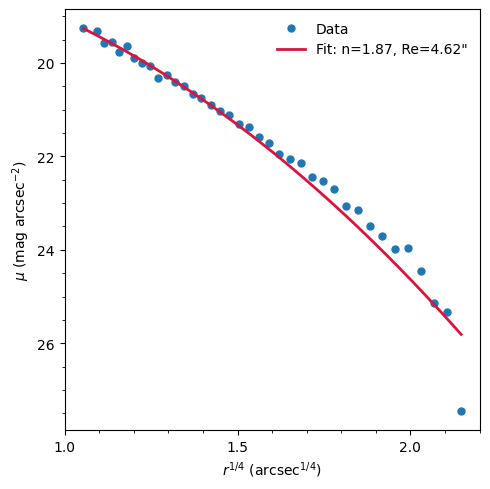

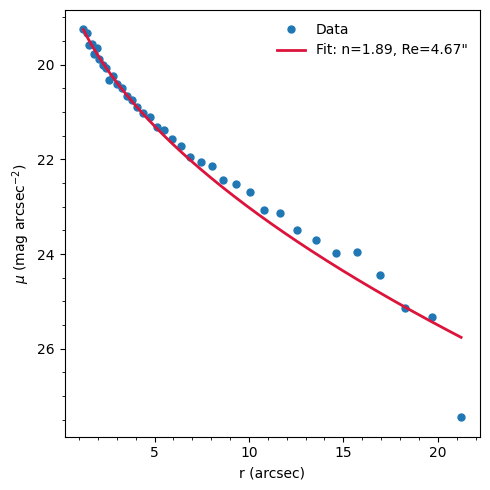

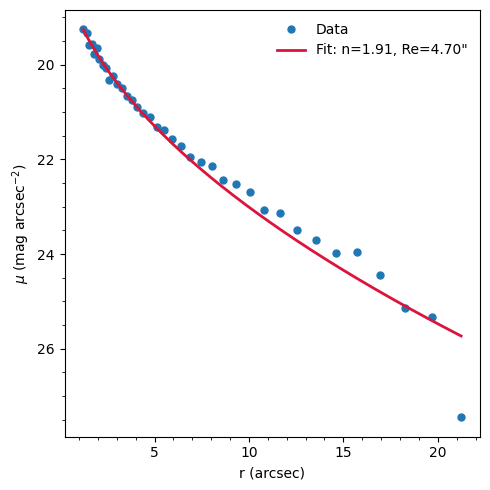

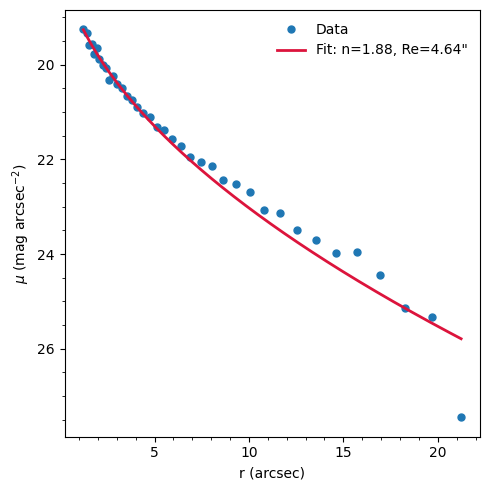

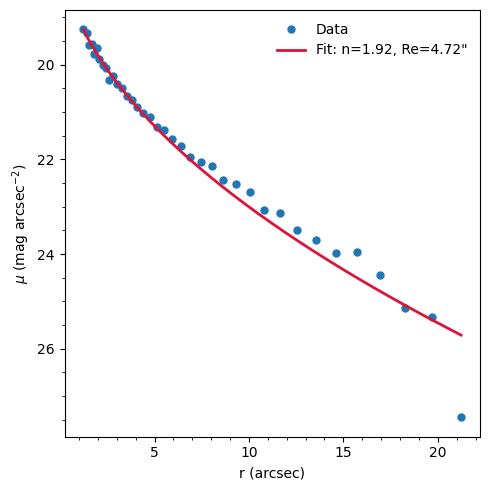

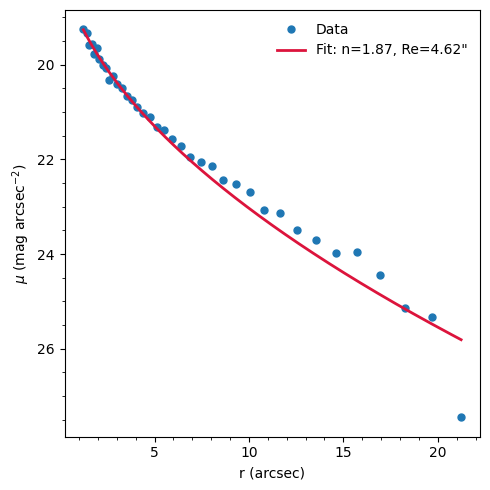


--- Sérsic Photometric Quantities ---
Best-fit n        = 1.895
Effective radius  = 4.672"  = 0.374 kpc  (D = 1.650e+07 pc)
Effective SB μ_e  = 21.160 mag/arcsec^2
Total flux F_tot  = 1192.62 (model units)
Total magnitude m_tot = 14.809 mag
Absolute magnitude M_abs = -16.279 mag
Central SB μ_0    = 17.401 mag/arcsec^2

--- Goodness of Fit ---
RMS residual = 0.3309 mag/arcsec^2
Chi^2 (σ=0.05) = 1664.07
Reduced Chi^2 = 47.54  (N=38, dof=35)


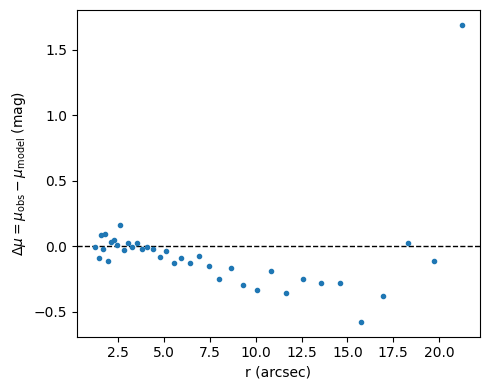

In [129]:
# --- FIXED-n Sersic scan (background-subtracted image in variable bkg_sub_p) ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from astropy.stats import sigma_clip
from photutils.aperture import EllipticalAnnulus
from scipy.optimize import curve_fit

# =========================
# USER SETTINGS
# =========================
img_sub = bkg_sub_p  # <-- already background-subtracted 2D ndarray

# Ellipse geometry & calibration
x0, y0 = 805.0, 1012.0    # center [pix]
q = 0.85                  # axis ratio b/a
theta = 0.0               # PA [rad]
s = 0.396                 # arcsec / pixel
ZP = 22.5                 # zeropoint (mag at 1 count/arcsec^2)

# Radial sampling & cleaning
nbins = 40
clip_sigma = 3.0
top_trim = 95.0           # drop top X% per annulus (stars/cosmic rays)
RMIN_ARCSEC = 1.2        # e.g. 1.2 to exclude PSF core
RMAX_ARCSEC = 24.0       # cap outer radius (arcsec); or None for auto

# n scan controls
N_COARSE_MIN, N_COARSE_MAX, N_COARSE_STEP = 0.30, 8.00, 0.02
N_FINE_HALFSPAN, N_FINE_STEP = 0.25, 0.005
TOPK = 5                  # number of best n to plot

# =========================
# Build annuli & SB profile
# =========================
h, w = img_sub.shape
r_min_pix = max(3, int(np.ceil(1.0 / s)))  # start just beyond ~1"
xm = min(x0, (w - 1) - x0)
ym = min(y0, (h - 1) - y0)
r_edge_safe = int(min(xm, ym / q))

if RMAX_ARCSEC is not None:
    r_cap_pix = int(RMAX_ARCSEC / s)
    r_max_pix = min(r_edge_safe - 3, r_cap_pix)
else:
    r_max_pix = r_edge_safe - 3
r_max_pix = max(r_min_pix + 3, r_max_pix)

edges = np.geomspace(r_min_pix, r_max_pix, nbins + 1)
sma_pix = np.sqrt(edges[:-1] * edges[1:])

ints_pix = []
for a_in, a_out in zip(edges[:-1], edges[1:]):
    ann = EllipticalAnnulus((x0, y0), a_in=a_in, a_out=a_out,
                            b_in=q*a_in, b_out=q*a_out, theta=theta)
    m = ann.to_mask(method='center')
    m = m[0] if isinstance(m, list) else m
    cut = m.cutout(img_sub)
    if cut is None:
        ints_pix.append(np.nan); continue
    vals = cut[m.data > 0]
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan); continue
    vals = sigma_clip(vals, sigma=clip_sigma, maxiters=3, masked=False)
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan); continue
    hi = np.nanpercentile(vals, top_trim)
    ints_pix.append(float(np.nanmedian(vals[vals <= hi])))

ints_pix = np.asarray(ints_pix, float)
good = np.isfinite(ints_pix) & (ints_pix > 0)
sma_pix = sma_pix[good]
ints_pix = ints_pix[good]

r_arcsec = sma_pix * s
I_as2 = ints_pix / (s**2)
mu = ZP - 2.5 * np.log10(I_as2)

m = np.isfinite(r_arcsec) & np.isfinite(mu)
if RMIN_ARCSEC is not None: m &= (r_arcsec >= RMIN_ARCSEC)
if RMAX_ARCSEC is not None: m &= (r_arcsec <= RMAX_ARCSEC)
r = r_arcsec[m].astype(float)
mu_arr = mu[m].astype(float)
I_data = 10**((ZP - mu_arr) / 2.5)

# =========================
# Fixed-n scan (no sky term)
# =========================
def b_n(n):
    return 2*n - 1.0/3.0 + 4.0/(405.0*n) + 46.0/(25515.0*n**2)

def sersic_I_fixedn(r, Ie, Re, n):
    return Ie * np.exp(-b_n(n) * ((r / Re)**(1.0/n) - 1.0))

def mu_from_I(I):
    I = np.clip(I, 1e-300, None)
    return ZP - 2.5*np.log10(I)

Re_bounds = (0.05, max(0.06, 1.2*np.max(r)))
Ie_bounds = (1e-12, np.inf)

def fit_fixed_n(nval):
    Ie0 = np.percentile(I_data, 85.0)
    Re0 = max(0.05, 0.25*np.max(r))
    p0 = [Ie0, Re0]
    bounds = ([Ie_bounds[0], Re_bounds[0]],
              [Ie_bounds[1], Re_bounds[1]])
    try:
        popt, _ = curve_fit(lambda rr, Ie, Re: sersic_I_fixedn(rr, Ie, Re, nval),
                            r, I_data, p0=p0, bounds=bounds, maxfev=20000)
        Ie, Re = popt
        mu_model = mu_from_I(sersic_I_fixedn(r, Ie, Re, nval))
        rms = float(np.sqrt(np.nanmean((mu_arr - mu_model)**2)))
        return dict(n=nval, Ie=Ie, Re=Re, rms=rms)
    except Exception:
        return None

# coarse scan
n_grid_coarse = np.arange(N_COARSE_MIN, N_COARSE_MAX + 1e-9, N_COARSE_STEP)
cands = []
for nv in n_grid_coarse:
    out = fit_fixed_n(nv)
    if out is not None and np.isfinite(out['rms']):
        cands.append(out)
best_coarse = min(cands, key=lambda d: d['rms'])

# fine scan around coarse best
n_best = best_coarse['n']
n_grid_fine = np.arange(max(N_COARSE_MIN, n_best - N_FINE_HALFSPAN),
                        min(N_COARSE_MAX, n_best + N_FINE_HALFSPAN) + 1e-9,
                        N_FINE_STEP)
for nv in n_grid_fine:
    out = fit_fixed_n(nv)
    if out is not None and np.isfinite(out['rms']):
        cands.append(out)

# rank and take top-K distinct n
cands.sort(key=lambda d: d['rms'])
best = []
for c in cands:
    if not any(abs(c['n'] - b['n']) < 0.01 for b in best):
        best.append(c)
bestk = best[:TOPK]
best_global = bestk[0]

print(f"Global best n = {best_global['n']:.3f}, Re = {best_global['Re']:.3f}\"  "
      f"RMS(μ) = {best_global['rms']:.4f} mag  (from {len(cands)} fits)")

print("\nTop fits:")
for i, f in enumerate(bestk, 1):
    print(f" {i:>2d}) n={f['n']:.3f}, Re={f['Re']:.3f}\"  Ie={f['Ie']:.4g}  RMS={f['rms']:.4f} mag")

# =========================
# Plotting (five in r^{1/4}, five in r)
# =========================
def style_axes(ax, xmode):
    ax.yaxis.set_major_locator(MultipleLocator(2.0))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.invert_yaxis()
    if xmode == 'r14':
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))
        ax.set_xlabel(r'$r^{1/4}$ (arcsec$^{1/4}$)')
    else:
        ax.xaxis.set_major_locator(MultipleLocator(5.0))
        ax.xaxis.set_minor_locator(MultipleLocator(1.0))
        ax.set_xlabel('r (arcsec)')
    ax.set_ylabel(r'$\mu$ (mag arcsec$^{-2}$)')

xx = np.linspace(r.min(), r.max(), 800)
xx14 = xx**0.25
r14 = r**0.25

# r^{1/4}
for f in bestk:
    mu_fit = mu_from_I(sersic_I_fixedn(xx, f['Ie'], f['Re'], f['n']))
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(r14, mu_arr, '.', ms=10, label='Data')
    ax.plot(xx14, mu_fit, '-', lw=2.0, color='crimson',
            label=f"Fit: n={f['n']:.2f}, Re={f['Re']:.2f}\"")
    style_axes(ax, 'r14')
    # ax.set_title('Sérsic fits (background-subtracted)')
    ax.legend(frameon=False)
    plt.tight_layout(); plt.show()

# r
for f in bestk:
    mu_fit = mu_from_I(sersic_I_fixedn(xx, f['Ie'], f['Re'], f['n']))
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(r, mu_arr, '.', ms=10, label='Data')
    ax.plot(xx, mu_fit, '-', lw=2.0, color='crimson',
            label=f"Fit: n={f['n']:.2f}, Re={f['Re']:.2f}\"")
    style_axes(ax, 'r')
    # ax.set_title('Sérsic fits (background-subtracted)')
    ax.legend(frameon=False)
    plt.tight_layout(); plt.show()



from scipy.special import gamma  # for Γ(2n)

# --- user distance in parsecs ---
D_pc = 1.65e7   # 16.5 Mpc; adjust as needed

# --- helper ---
def b_n(n):
    return 2*n - 1.0/3.0 + 4.0/(405.0*n) + 46.0/(25515.0*n**2)

def mu_from_I(I):
    I = np.clip(I, 1e-300, None)
    return ZP - 2.5*np.log10(I)

# --- extract best fit ---
n = best_global['n']
Re = best_global['Re']
Ie = best_global['Ie']

# if your fit included a sky term (raw FITS case), subtract it off:
Isky = best_global.get('Isky', 0.0)

# effective SB at Re
mu_e = mu_from_I(Ie)

# Re in kpc
arcsec_to_pc = D_pc * (np.pi / (180.0 * 3600.0))
Re_kpc = Re * arcsec_to_pc / 1e3

# total flux (model only, no sky)
bn = b_n(n)
F_tot = 2.0 * np.pi * Ie * (Re**2) * n * np.exp(bn) * (bn**(-2.0*n)) * gamma(2.0*n)

# apparent total magnitude
m_tot = ZP - 2.5*np.log10(F_tot)

# absolute magnitude
M_abs = m_tot - 5.0 * np.log10(D_pc / 10.0)

# central surface brightness
I0 = Ie * np.exp(bn)
mu0 = mu_from_I(I0)

print("\n--- Sérsic Photometric Quantities ---")
print(f"Best-fit n        = {n:.3f}")
print(f"Effective radius  = {Re:.3f}\"  = {Re_kpc:.3f} kpc  (D = {D_pc:.3e} pc)")
print(f"Effective SB μ_e  = {mu_e:.3f} mag/arcsec^2")
print(f"Total flux F_tot  = {F_tot:.6g} (model units)")
print(f"Total magnitude m_tot = {m_tot:.3f} mag")
print(f"Absolute magnitude M_abs = {M_abs:.3f} mag")
print(f"Central SB μ_0    = {mu0:.3f} mag/arcsec^2")
if Isky > 0:
    print(f"Fitted sky I_sky  = {Isky:.6g} (intensity units)")
    
    
def b_n(n):
    return 2*n - 1.0/3.0 + 4.0/(405.0*n) + 46.0/(25515.0*n**2)

def sersic_I(r, Ie, Re, n, Isky=0.0):
    return Ie * np.exp(-b_n(n) * ((r / Re)**(1.0/n) - 1.0)) + Isky

def mu_from_I(I):
    I = np.clip(I, 1e-300, None)
    return ZP - 2.5*np.log10(I)

# extract best-fit parameters
Ie   = best_global['Ie']
Re   = best_global['Re']
n    = best_global['n']
Isky = best_global.get('Isky', 0.0)

# model μ profile at fitted radii
mu_model = mu_from_I(sersic_I(r, Ie, Re, n, Isky))

# residuals
resid = mu_arr - mu_model

# --- RMS of residuals ---
rms = np.sqrt(np.nanmean(resid**2))

# --- Chi-square diagnostics ---
# If you don’t have real uncertainties, assume a uniform σ (e.g. 0.05 mag/arcsec^2).
sigma_assumed = 0.05
chi2 = np.sum((resid / sigma_assumed)**2)
ndof = len(resid) - (4 if 'Isky' in best_global else 3)  # free params: Ie, Re, n, (Isky optional)
chi2_red = chi2 / ndof

print("\n--- Goodness of Fit ---")
print(f"RMS residual = {rms:.4f} mag/arcsec^2")
print(f"Chi^2 (σ={sigma_assumed:.2f}) = {chi2:.2f}")
print(f"Reduced Chi^2 = {chi2_red:.2f}  (N={len(resid)}, dof={ndof})")

# --- Residual plot ---
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,4))
ax.axhline(0, color='k', ls='--', lw=1)
ax.plot(r, resid, 'o', ms=3)
ax.set_xlabel('r (arcsec)')
ax.set_ylabel(r'$\Delta \mu = \mu_{\mathrm{obs}} - \mu_{\mathrm{model}}$ (mag)')
# ax.set_title('Residuals of best Sérsic fit')
plt.tight_layout(); plt.show()


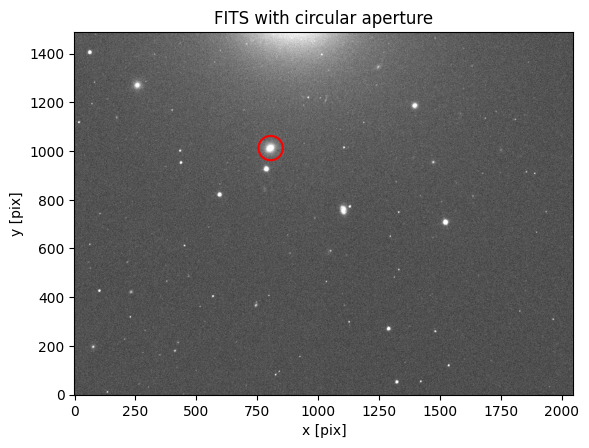

In [72]:
# ---- user inputs (pixels) ----
fits_path = "C:/Users/andre/Desktop/Astro/GalacticAstronomy/SurfaceBrightnessProfile/NGC4467.fits"
ext = 0
x0, y0 = 805.0, 1012.0     # center (x, y) in pixels
r_pix   = 50.0             # radius in pixels

# ---- load and plot ----
data = fits.getdata(fits_path, ext=ext).astype(float)
norm = ImageNormalize(data, interval=ZScaleInterval())

plt.figure(figsize=(6, 6))
plt.imshow(data, origin="lower", cmap="gray", norm=norm)
plt.xlabel("x [pix]"); plt.ylabel("y [pix]")
plt.title("FITS with circular aperture")

ap = CircularAperture((x0, y0), r=r_pix)
ap.plot(color="red", lw=1.5)   # overlay aperture

plt.tight_layout()
plt.show()


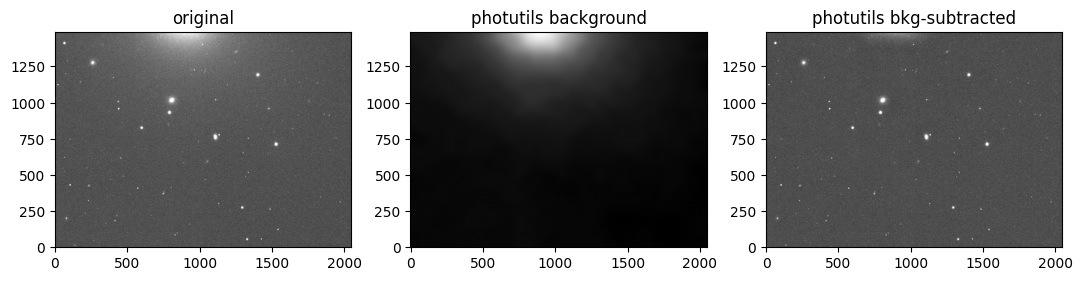

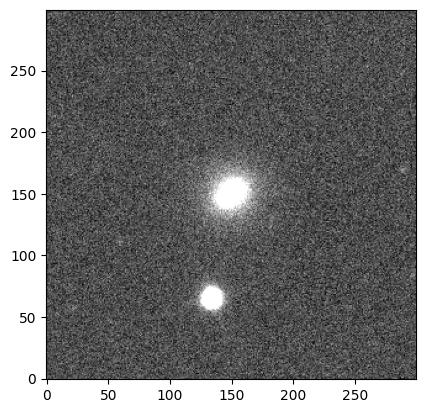

In [76]:
# Photutils path
from utils_bkg_sub import photutils_bkg

# --- photutils background ---
bkg_map_p, bkg_rms_p = photutils_bkg(img, bw=64, bh=64, fw=3, fh=3)
bkg_sub_p = img - bkg_map_p

# --- plot background subtracted ---
plt.figure(figsize=(13, 7))
plt.subplot(1,3,1); plt.imshow(img, origin='lower', cmap='gray', norm=norm); plt.title('original')
plt.subplot(1,3,2); plt.imshow(bkg_map_p, origin='lower', cmap='gray'); plt.title('photutils background')
plt.subplot(1,3,3); plt.imshow(bkg_sub_p, origin='lower', cmap='gray', norm=norm); plt.title('photutils bkg-subtracted')
plt.show()

bkg_img_zoom = bkg_sub_p[862:1162, 655:955]
plt.figure()
plt.imshow(bkg_img_zoom, origin='lower', cmap='gray', norm=norm)
plt.show()


Top 5 Sérsic fits (RMS in μ):
  1) n=2.337, Re=5.446"  Ie=2.712  RMS=3.5369 mag


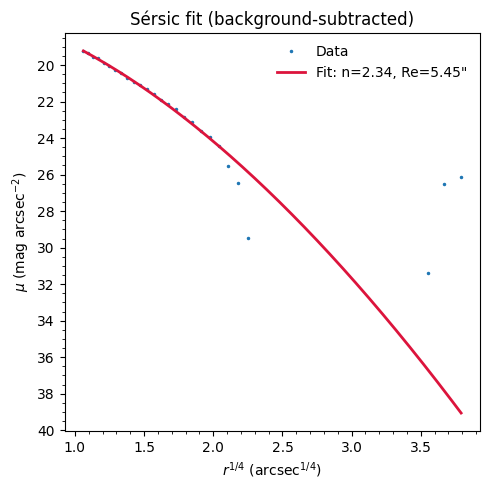

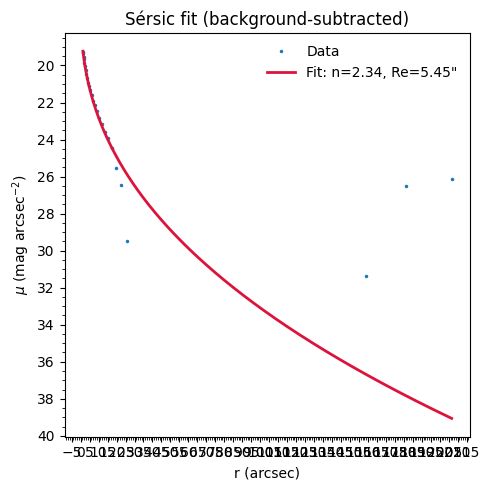

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from astropy.io import fits
from astropy.stats import sigma_clip
from astropy.visualization import ImageNormalize, ZScaleInterval
from photutils.aperture import EllipticalAnnulus
from scipy.optimize import curve_fit

# =========================
# USER SETTINGS
# =========================
# Prefer an in-memory background-subtracted image named `img_sub`.
# If not present, set fits_path to a file that is already bg-subtracted.
fits_path = "C:/Users/andre/Desktop/Astro/GalacticAstronomy/SurfaceBrightnessProfile/NGC4467.fits"  # e.g., "my_bgsub_image.fits"
ext = 0

# Geometry & calibration
x0, y0 = 805.0, 1012.0    # center [pix]
q = 0.85                  # axis ratio b/a
theta = 0.0               # PA [rad]
s = 0.396                 # arcsec per pixel
ZP = 22.5                 # zeropoint (mag for 1 count per arcsec^2)

# Radial sampling
nbins = 40
clip_sigma = 3.0
top_trim = 95.0           # trim brightest X% per annulus (suppress stars)

# Optional fit range in arcsec (set to None to disable)
RMIN_ARCSEC = None
RMAX_ARCSEC = None  # e.g. 100.0 to cap at 100″

# =========================
# LOAD BACKGROUND-SUBTRACTED IMAGE
# =========================
try:
    img_sub  # noqa: F821
except NameError:
    if fits_path is None:
        raise RuntimeError("Provide in-memory 'img_sub' or set 'fits_path' to a bg-subtracted FITS.")
    with fits.open(fits_path, memmap=True) as hdul:
        img_sub = hdul[ext].data.astype(float, copy=False)

# =========================
# BUILD ANNULI GRID
# =========================
h, w = img_sub.shape
r_min_pix = max(3, int(np.ceil(1.0 / s)))  # start just beyond ~1″

# ensure both a_out and b_out stay inside the image
xm = min(x0, (w - 1) - x0)
ym = min(y0, (h - 1) - y0)
r_edge_safe = int(min(xm, ym / q))

# optional hard cap in arcsec
if RMAX_ARCSEC is not None:
    r_cap_pix = int(RMAX_ARCSEC / s)
    r_max_pix = min(r_edge_safe - 3, r_cap_pix)
else:
    r_max_pix = r_edge_safe - 3
r_max_pix = max(r_min_pix + 3, r_max_pix)

edges = np.geomspace(r_min_pix, r_max_pix, nbins + 1)
sma_pix = np.sqrt(edges[:-1] * edges[1:])  # geometric midpoints

# =========================
# SAMPLE MEDIAN INTENSITY PER ANNULUS (SKY ALREADY REMOVED)
# =========================
ints_pix = []
for a_in, a_out in zip(edges[:-1], edges[1:]):
    ann = EllipticalAnnulus((x0, y0),
                            a_in=a_in, a_out=a_out,
                            b_in=q * a_in, b_out=q * a_out,
                            theta=theta)
    m = ann.to_mask(method='center')
    m = m[0] if isinstance(m, list) else m

    cut = m.cutout(img_sub)
    if cut is None:
        ints_pix.append(np.nan); continue

    vals = cut[m.data > 0]
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan); continue

    vals = sigma_clip(vals, sigma=clip_sigma, maxiters=3, masked=False)
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan); continue

    hi = np.nanpercentile(vals, top_trim)
    vals = vals[vals <= hi]

    ints_pix.append(float(np.nanmedian(vals)))

ints_pix = np.asarray(ints_pix, float)
good = np.isfinite(ints_pix) & (ints_pix > 0)
sma_pix = sma_pix[good]
ints_pix = ints_pix[good]

# convert to SB
r_arcsec = sma_pix * s
I_as2 = ints_pix / (s**2)
mu = ZP - 2.5 * np.log10(I_as2)

# optionally restrict fit range
sel = np.isfinite(r_arcsec) & np.isfinite(mu)
if RMIN_ARCSEC is not None:
    sel &= (r_arcsec >= RMIN_ARCSEC)
if RMAX_ARCSEC is not None:
    sel &= (r_arcsec <= RMAX_ARCSEC)
r_arcsec = r_arcsec[sel]
mu = mu[sel]

# =========================
# SÉRSIC FITTER (NO SKY TERM)
# =========================
def b_n(n):
    return 2*n - 1.0/3.0 + 4.0/(405.0*n) + 46.0/(25515.0*n**2)

def sersic_I(r, Ie, Re, n):
    return Ie * np.exp(-b_n(n) * ((r / Re)**(1.0/n) - 1.0))

def mu_from_I(I):
    I = np.clip(I, 1e-300, None)
    return ZP - 2.5*np.log10(I)

# work in intensity for fitting
I_data = 10**((ZP - mu) / 2.5)
mfit = np.isfinite(I_data) & (I_data > 0)
r = r_arcsec[mfit]
mu_arr = mu[mfit]
I_data = I_data[mfit]

# scan seeds for n, refine each with curve_fit, rank by RMS in μ-space
n_seeds = np.r_[np.linspace(0.6, 1.2, 4),
                np.linspace(1.3, 3.0, 8),
                np.linspace(3.2, 5.5, 7)]
n_bounds = (0.3, 10.0)
Re_bounds = (0.05, max(0.06, 1.2*np.max(r)))
Ie_bounds = (1e-12, np.inf)

def fit_once(n0):
    Ie0 = np.percentile(I_data, 85.0)
    Re0 = max(0.05, 0.25*np.max(r))
    p0  = [Ie0, Re0, float(n0)]
    bounds = ([Ie_bounds[0], Re_bounds[0], n_bounds[0]],
              [Ie_bounds[1], Re_bounds[1], n_bounds[1]])
    try:
        popt, pcov = curve_fit(sersic_I, r, I_data, p0=p0, bounds=bounds, maxfev=20000)
        Ie, Re, n = popt
        mu_model = mu_from_I(sersic_I(r, Ie, Re, n))
        rms = float(np.sqrt(np.nanmean((mu_arr - mu_model)**2)))
        return dict(Ie=Ie, Re=Re, n=n, rms=rms)
    except Exception:
        return None

fits = []
for n0 in n_seeds:
    out = fit_once(n0)
    if out is not None and np.isfinite(out['rms']):
        fits.append(out)

fits.sort(key=lambda d: d['rms'])
best = []
for f in fits:
    if not any(abs(f['n'] - g['n']) < 0.02 for g in best):  # keep distinct n
        best.append(f)
best5 = best[:5]

print("Top 5 Sérsic fits (RMS in μ):")
for i, f in enumerate(best5, 1):
    print(f" {i:>2d}) n={f['n']:.3f}, Re={f['Re']:.3f}\"  Ie={f['Ie']:.4g}  RMS={f['rms']:.4f} mag")

# =========================
# PLOTTING HELPERS (literature-like axes)
# =========================
def style_axes(ax, xmode):
    # y: even integers, 3 minors between (0.5)
    ax.yaxis.set_major_locator(MultipleLocator(2.0))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.invert_yaxis()
    if xmode == 'r14':
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))
        ax.set_xlabel(r'$r^{1/4}$ (arcsec$^{1/4}$)')
    else:
        ax.xaxis.set_major_locator(MultipleLocator(5.0))
        ax.xaxis.set_minor_locator(MultipleLocator(1.0))
        ax.set_xlabel('r (arcsec)')
    ax.set_ylabel(r'$\mu$ (mag arcsec$^{-2}$)')

# =========================
# MAKE FIGURES: five in r^{1/4}, five in r
# =========================
# r^{1/4}
xx = np.linspace(r.min(), r.max(), 600)
xx14 = xx**0.25
r14 = r**0.25

for f in best5:
    Ie, Re, n = f['Ie'], f['Re'], f['n']
    mu_fit = mu_from_I(sersic_I(xx, Ie, Re, n))

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(r14, mu_arr, '.', ms=3, label='Data')
    ax.plot(xx14, mu_fit, '-', lw=2.0, color='crimson', label=f'Fit: n={n:.2f}, Re={Re:.2f}"')
    style_axes(ax, 'r14')
    ax.set_title('Sérsic fit (background-subtracted)')
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()

# r
for f in best5:
    Ie, Re, n = f['Ie'], f['Re'], f['n']
    mu_fit = mu_from_I(sersic_I(xx, Ie, Re, n))

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(r, mu_arr, '.', ms=3, label='Data')
    ax.plot(xx, mu_fit, '-', lw=2.0, color='crimson', label=f'Fit: n={n:.2f}, Re={Re:.2f}"')
    style_axes(ax, 'r')
    ax.set_title('Sérsic fit (background-subtracted)')
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()


Top 5 Sérsic fits (ranked by RMS of μ residuals):
  1) n=2.964, Re=7.170"  Ie=1.648  RMS=1.0030 mag


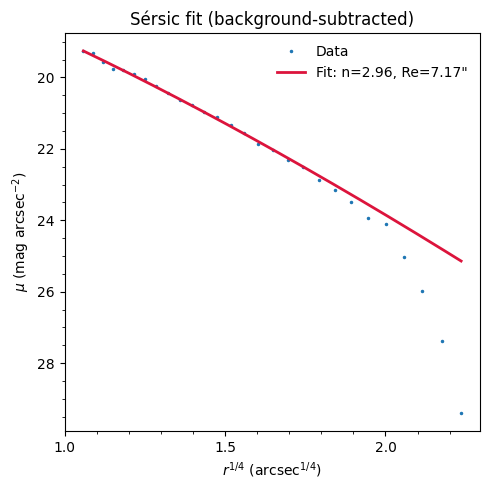

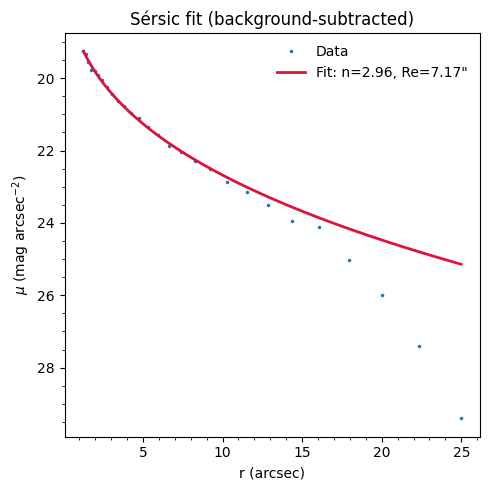

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from astropy.stats import sigma_clip
from photutils.aperture import EllipticalAnnulus
from scipy.optimize import curve_fit

# =========================
# USER SETTINGS
# =========================
# Background-subtracted image already in memory:
#   bkg_sub_p : 2D ndarray  (e.g., img - background)
img_sub = bkg_sub_p

# Ellipse geometry & calibration
x0, y0 = 805.0, 1012.0    # galaxy center [pix]
q = 0.85                  # axis ratio b/a
theta = 0.0               # PA [rad] (Photutils convention)
s = 0.396                 # arcsec / pixel
ZP = 22.5                 # zeropoint (mag for 1 count per arcsec^2)

# Radial sampling and cleaning
nbins = 40
clip_sigma = 3.0
top_trim = 95.0           # drop top X% per annulus (stars/cosmic rays)

# Optional fit-range in arcsec (set to None to disable)
RMIN_ARCSEC = None
RMAX_ARCSEC = 100.0       # example cap at 100″; set None to disable

# =========================
# BUILD ANNULI GRID
# =========================
h, w = img_sub.shape
r_min_pix = max(3, int(np.ceil(1.0 / s)))  # start ~>1″
xm = min(x0, (w - 1) - x0)
ym = min(y0, (h - 1) - y0)
r_edge_safe = int(min(xm, ym / q))

if RMAX_ARCSEC is not None:
    r_cap_pix = int(RMAX_ARCSEC / s)
    r_max_pix = min(r_edge_safe - 3, r_cap_pix)
else:
    r_max_pix = r_edge_safe - 3
r_max_pix = max(r_min_pix + 3, r_max_pix)

edges = np.geomspace(r_min_pix, r_max_pix, nbins + 1)
sma_pix = np.sqrt(edges[:-1] * edges[1:])  # geometric midpoints

# =========================
# SAMPLE MEDIAN INTENSITY PER ANNULUS (SKY ALREADY REMOVED)
# =========================
ints_pix = []
for a_in, a_out in zip(edges[:-1], edges[1:]):
    ann = EllipticalAnnulus((x0, y0),
                            a_in=a_in, a_out=a_out,
                            b_in=q * a_in, b_out=q * a_out,
                            theta=theta)
    m = ann.to_mask(method='center')
    m = m[0] if isinstance(m, list) else m

    cut = m.cutout(img_sub)
    if cut is None:
        ints_pix.append(np.nan); continue

    vals = cut[m.data > 0]
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan); continue

    vals = sigma_clip(vals, sigma=clip_sigma, maxiters=3, masked=False)
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan); continue

    hi = np.nanpercentile(vals, top_trim)
    vals = vals[vals <= hi]
    ints_pix.append(float(np.nanmedian(vals)))

ints_pix = np.asarray(ints_pix, float)
good = np.isfinite(ints_pix) & (ints_pix > 0)
sma_pix = sma_pix[good]
ints_pix = ints_pix[good]

# Convert to SB and optionally restrict fit range
r_arcsec = sma_pix * s
I_as2 = ints_pix / (s**2)
mu = ZP - 2.5 * np.log10(I_as2)

mask = np.isfinite(r_arcsec) & np.isfinite(mu)
if RMIN_ARCSEC is not None: mask &= (r_arcsec >= RMIN_ARCSEC)
if RMAX_ARCSEC is not None: mask &= (r_arcsec <= RMAX_ARCSEC)
r_arcsec = r_arcsec[mask]
mu = mu[mask]

# =========================
# SÉRSIC FITS (NO SKY TERM) — RANK BY RMS IN μ
# =========================
def b_n(n):
    return 2*n - 1.0/3.0 + 4.0/(405.0*n) + 46.0/(25515.0*n**2)

def sersic_I(r, Ie, Re, n):
    return Ie * np.exp(-b_n(n) * ((r / Re)**(1.0/n) - 1.0))

def mu_from_I(I):
    I = np.clip(I, 1e-300, None)
    return ZP - 2.5*np.log10(I)

# fit in INTENSITY space
I_data = 10**((ZP - mu) / 2.5)
mfit = np.isfinite(I_data) & (I_data > 0)
r = r_arcsec[mfit]
mu_arr = mu[mfit]
I_data = I_data[mfit]

n_seeds = np.r_[np.linspace(0.6, 1.2, 4),
                np.linspace(1.3, 3.0, 8),
                np.linspace(3.2, 5.5, 7)]
n_bounds = (0.3, 10.0)
Re_bounds = (0.05, max(0.06, 1.2*np.max(r)))
Ie_bounds = (1e-12, np.inf)

def fit_once(n0):
    Ie0 = np.percentile(I_data, 85.0)
    Re0 = max(0.05, 0.25*np.max(r))
    p0  = [Ie0, Re0, float(n0)]
    bounds = ([Ie_bounds[0], Re_bounds[0], n_bounds[0]],
              [Ie_bounds[1], Re_bounds[1], n_bounds[1]])
    try:
        popt, _ = curve_fit(sersic_I, r, I_data, p0=p0, bounds=bounds, maxfev=20000)
        Ie, Re, n = popt
        mu_model = mu_from_I(sersic_I(r, Ie, Re, n))
        rms = float(np.sqrt(np.nanmean((mu_arr - mu_model)**2)))
        return dict(Ie=Ie, Re=Re, n=n, rms=rms)
    except Exception:
        return None

fits = []
for n0 in n_seeds:
    out = fit_once(n0)
    if out is not None and np.isfinite(out['rms']):
        fits.append(out)

fits.sort(key=lambda d: d['rms'])
best = []
for f in fits:
    if not any(abs(f['n'] - g['n']) < 0.02 for g in best):  # distinct n values
        best.append(f)
best5 = best[:5]

print("Top 5 Sérsic fits (ranked by RMS of μ residuals):")
for i, f in enumerate(best5, 1):
    print(f" {i:>2d}) n={f['n']:.3f}, Re={f['Re']:.3f}\"  Ie={f['Ie']:.4g}  RMS={f['rms']:.4f} mag")

# =========================
# PLOTTING HELPERS (literature-like ticks)
# =========================
def style_axes(ax, xmode):
    # y: even integers with 3 minor ticks in between (0.5 spacing)
    ax.yaxis.set_major_locator(MultipleLocator(2.0))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.invert_yaxis()
    if xmode == 'r14':
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))  # 4 minors between majors
        ax.set_xlabel(r'$r^{1/4}$ (arcsec$^{1/4}$)')
    else:
        ax.xaxis.set_major_locator(MultipleLocator(5.0))
        ax.xaxis.set_minor_locator(MultipleLocator(1.0))  # 4 minors between majors
        ax.set_xlabel('r (arcsec)')
    ax.set_ylabel(r'$\mu$ (mag arcsec$^{-2}$)')

# =========================
# MAKE FIGURES: five in r^{1/4}, five in r
# =========================
xx = np.linspace(r.min(), r.max(), 600)
xx14 = xx**0.25
r14 = r**0.25

# r^{1/4} plots
for f in best5:
    Ie, Re, n = f['Ie'], f['Re'], f['n']
    mu_fit = mu_from_I(sersic_I(xx, Ie, Re, n))
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(r14, mu_arr, '.', ms=3, label='Data')
    ax.plot(xx14, mu_fit, '-', lw=2.0, color='crimson', label=f'Fit: n={n:.2f}, Re={Re:.2f}"')
    style_axes(ax, 'r14')
    ax.set_title('Sérsic fit (background-subtracted)')
    ax.legend(frameon=False)
    plt.tight_layout(); plt.show()

# r plots
for f in best5:
    Ie, Re, n = f['Ie'], f['Re'], f['n']
    mu_fit = mu_from_I(sersic_I(xx, Ie, Re, n))
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(r, mu_arr, '.', ms=3, label='Data')
    ax.plot(xx, mu_fit, '-', lw=2.0, color='crimson', label=f'Fit: n={n:.2f}, Re={Re:.2f}"')
    style_axes(ax, 'r')
    ax.set_title('Sérsic fit (background-subtracted)')
    ax.legend(frameon=False)
    plt.tight_layout(); plt.show()


Top 5 Sérsic indices by RMS(μ):
  1) n=1.600, Re=4.063"  Ie=4.309  RMS=0.5250 mag
  2) n=1.550, Re=3.978"  Ie=4.469  RMS=0.5292 mag
  3) n=1.650, Re=4.150"  Ie=4.155  RMS=0.5305 mag
  4) n=1.700, Re=4.238"  Ie=4.007  RMS=0.5431 mag
  5) n=1.500, Re=3.894"  Ie=4.635  RMS=0.5459 mag


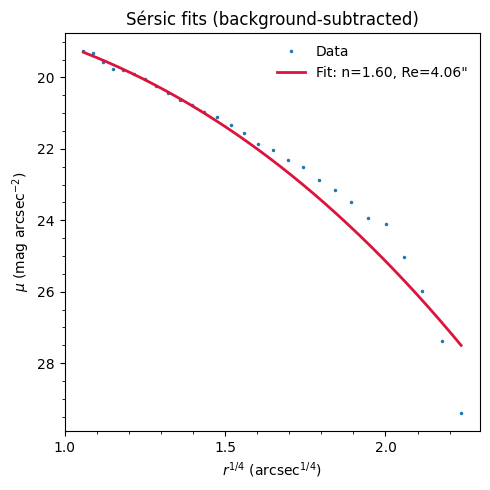

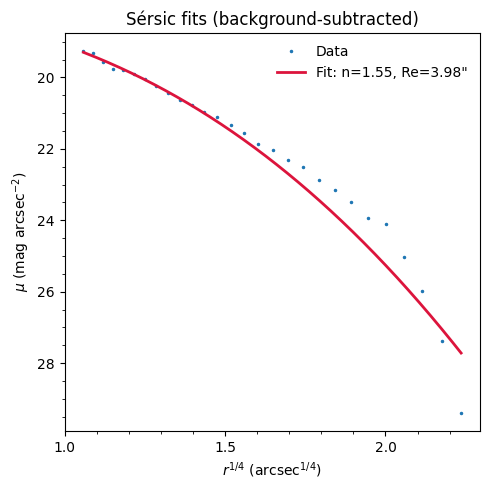

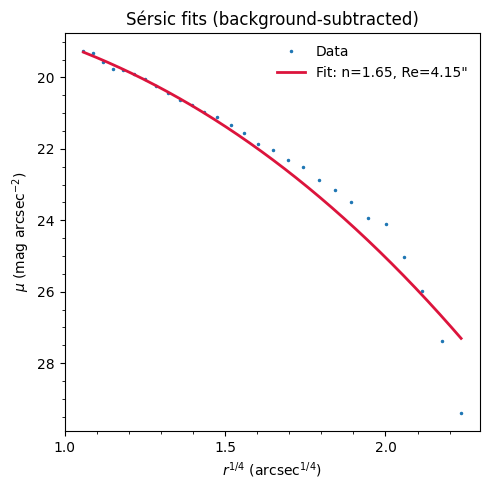

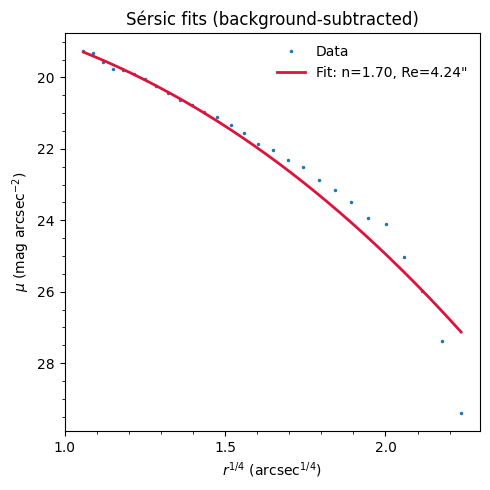

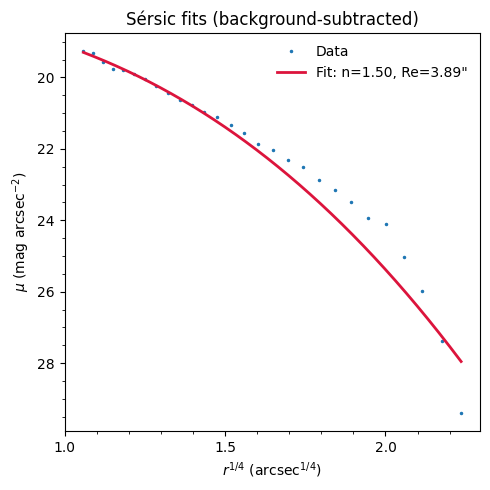

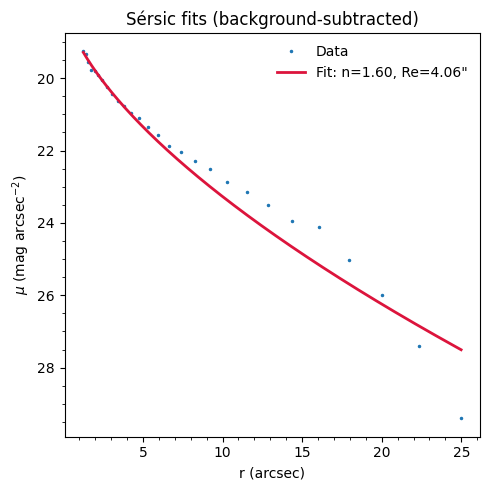

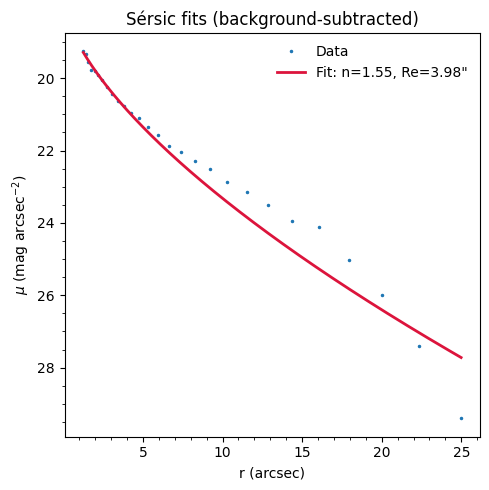

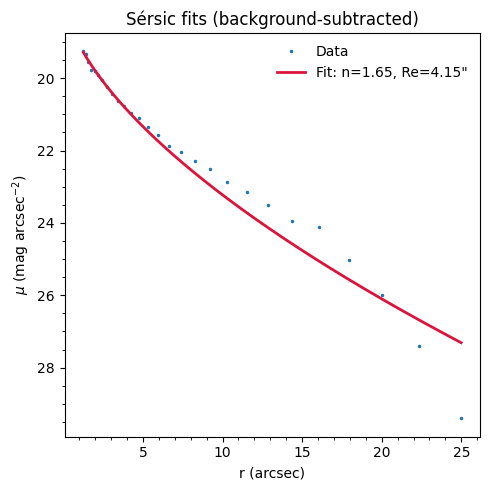

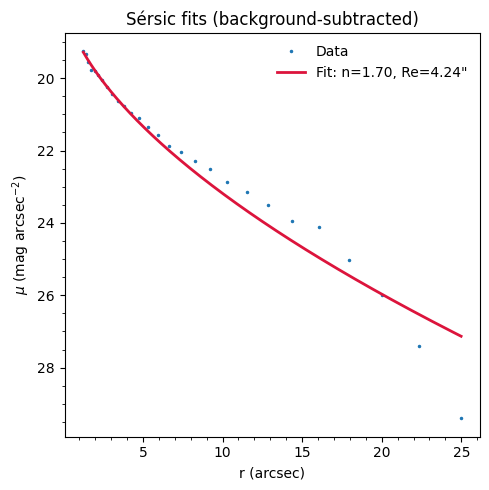

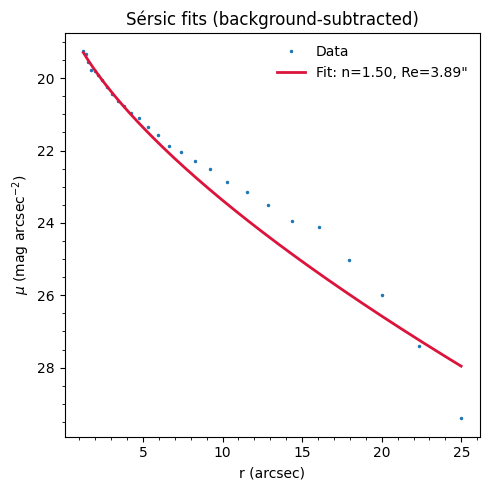

In [104]:
# =========================
# SÉRSIC FITS (FIXED n SCAN) — GUARANTEE 5 DISTINCT n
# =========================
from scipy.optimize import curve_fit

def b_n(n):
    return 2*n - 1.0/3.0 + 4.0/(405.0*n) + 46.0/(25515.0*n**2)

def sersic_I_fixedn(r, Ie, Re, n):
    return Ie * np.exp(-b_n(n) * ((r / Re)**(1.0/n) - 1.0))

def mu_from_I(I):
    I = np.clip(I, 1e-300, None)
    return ZP - 2.5*np.log10(I)

# work in INTENSITY space
I_data = 10**((ZP - mu) / 2.5)
mfit = np.isfinite(I_data) & (I_data > 0)
r = r_arcsec[mfit]
mu_arr = mu[mfit]
I_data = I_data[mfit]

# grid of n to test (adjust step for speed/precision)
n_grid = np.arange(0.6, 6.05, 0.05)

Re_bounds = (0.05, max(0.06, 1.2*np.max(r)))
Ie_bounds = (1e-12, np.inf)

def fit_fixed_n(nval):
    # initial guesses
    Ie0 = np.percentile(I_data, 85.0)
    Re0 = max(0.05, 0.25*np.max(r))
    p0  = [Ie0, Re0]
    bounds = ([Ie_bounds[0], Re_bounds[0]],
              [Ie_bounds[1], Re_bounds[1]])
    try:
        popt, _ = curve_fit(lambda rr, Ie, Re: sersic_I_fixedn(rr, Ie, Re, nval),
                            r, I_data, p0=p0, bounds=bounds, maxfev=20000)
        Ie, Re = popt
        mu_model = mu_from_I(sersic_I_fixedn(r, Ie, Re, nval))
        rms = float(np.sqrt(np.nanmean((mu_arr - mu_model)**2)))
        return dict(n=nval, Ie=Ie, Re=Re, rms=rms)
    except Exception:
        return None

cands = []
for nval in n_grid:
    out = fit_fixed_n(nval)
    if out is not None and np.isfinite(out['rms']):
        cands.append(out)

# rank n by RMS (smaller is better) and take top 5
cands.sort(key=lambda d: d['rms'])
best5 = cands[:5]

print("Top 5 Sérsic indices by RMS(μ):")
for i, f in enumerate(best5, 1):
    print(f" {i:>2d}) n={f['n']:.3f}, Re={f['Re']:.3f}\"  Ie={f['Ie']:.4g}  RMS={f['rms']:.4f} mag")

# --- plotting (same styling as before) ---
from matplotlib.ticker import MultipleLocator
def style_axes(ax, xmode):
    ax.yaxis.set_major_locator(MultipleLocator(2.0))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.invert_yaxis()
    if xmode == 'r14':
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))
        ax.set_xlabel(r'$r^{1/4}$ (arcsec$^{1/4}$)')
    else:
        ax.xaxis.set_major_locator(MultipleLocator(5.0))
        ax.xaxis.set_minor_locator(MultipleLocator(1.0))
        ax.set_xlabel('r (arcsec)')
    ax.set_ylabel(r'$\mu$ (mag arcsec$^{-2}$)')

xx = np.linspace(r.min(), r.max(), 600)
xx14 = xx**0.25
r14 = r**0.25

# r^{1/4} figures (five)
for f in best5:
    Ie, Re, n = f['Ie'], f['Re'], f['n']
    mu_fit = mu_from_I(sersic_I_fixedn(xx, Ie, Re, n))
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(r14, mu_arr, '.', ms=3, label='Data')
    ax.plot(xx14, mu_fit, '-', lw=2.0, color='crimson', label=f'Fit: n={n:.2f}, Re={Re:.2f}\"')
    style_axes(ax, 'r14')
    ax.set_title('Sérsic fits (background-subtracted)')
    ax.legend(frameon=False)
    plt.tight_layout(); plt.show()

# r figures (five)
for f in best5:
    Ie, Re, n = f['Ie'], f['Re'], f['n']
    mu_fit = mu_from_I(sersic_I_fixedn(xx, Ie, Re, n))
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(r, mu_arr, '.', ms=3, label='Data')
    ax.plot(xx, mu_fit, '-', lw=2.0, color='crimson', label=f'Fit: n={n:.2f}, Re={Re:.2f}\"')
    style_axes(ax, 'r')
    ax.set_title('Sérsic fits (background-subtracted)')
    ax.legend(frameon=False)
    plt.tight_layout(); plt.show()


Using 27 points between 1.256" and 22.369"
Free-n best: n=2.976, Re=7.206", RMS=0.6123 mag
Fixed-n best: n=1.820, Re=4.457", RMS=0.3219 mag


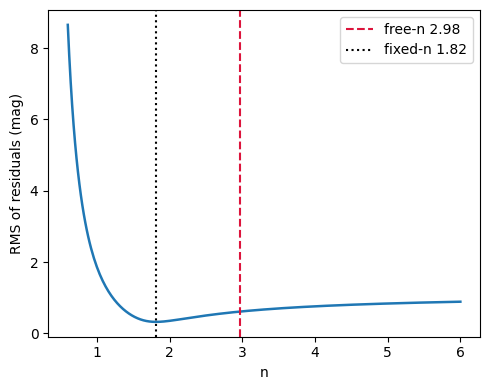

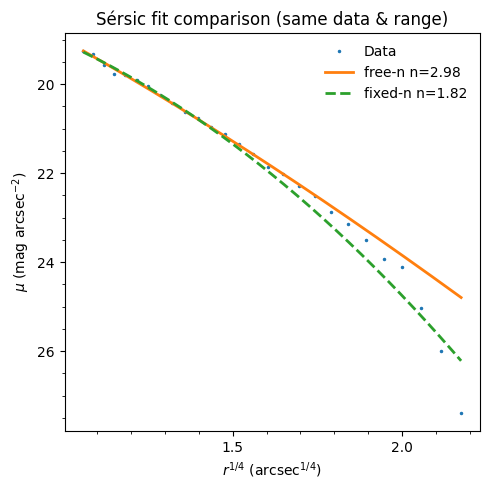

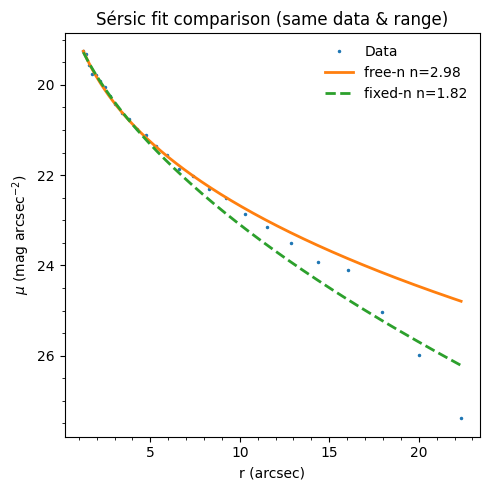

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.optimize import curve_fit

# ---- inputs: SAME arrays for both methods ----
# r_arcsec, mu: background-subtracted SB profile (your arrays)
ZP = 22.5

# ---- enforce identical fit range (edit these!) ----
RMIN_ARCSEC = 0.87    # match literature inner cut, or None
RMAX_ARCSEC = 23.9    # match literature outer cut, or None

m = np.isfinite(r_arcsec) & np.isfinite(mu)
if RMIN_ARCSEC is not None: m &= (r_arcsec >= RMIN_ARCSEC)
if RMAX_ARCSEC is not None: m &= (r_arcsec <= RMAX_ARCSEC)
r = r_arcsec[m].astype(float)
mu_arr = mu[m].astype(float)

def b_n(n):
    return 2*n - 1/3 + 4/(405*n) + 46/(25515*n**2)

def sersic_I(r, Ie, Re, n):
    return Ie * np.exp(-b_n(n) * ((r/Re)**(1/n) - 1))

def mu_from_I(I):
    I = np.clip(I, 1e-300, None)
    return ZP - 2.5*np.log10(I)

# convert μ -> intensity for fitting
I_data = 10**((ZP - mu_arr)/2.5)

# ===== A) FREE-n NONLINEAR FIT (many seeds) =====
n_seeds = np.r_[np.linspace(0.6, 1.2, 4),
                np.linspace(1.3, 3.0, 8),
                np.linspace(3.2, 5.5, 7)]
Ie_bounds = (1e-12, np.inf)
Re_bounds = (0.05, max(0.06, 1.2*np.max(r)))
n_bounds  = (0.3, 10.0)

def fit_free_n(n0):
    Ie0 = np.percentile(I_data, 85.0)
    Re0 = max(0.05, 0.25*np.max(r))
    p0  = [Ie0, Re0, float(n0)]
    bounds = ([Ie_bounds[0], Re_bounds[0], n_bounds[0]],
              [Ie_bounds[1], Re_bounds[1], n_bounds[1]])
    try:
        popt,_ = curve_fit(sersic_I, r, I_data, p0=p0, bounds=bounds, maxfev=20000)
        Ie, Re, n = popt
        rms = np.sqrt(np.mean((mu_arr - mu_from_I(sersic_I(r, Ie, Re, n)))**2))
        return dict(Ie=Ie, Re=Re, n=n, rms=rms)
    except Exception:
        return None

cands_free = [fit_free_n(n0) for n0 in n_seeds]
cands_free = [c for c in cands_free if c is not None and np.isfinite(c['rms'])]
cands_free.sort(key=lambda d: d['rms'])
best_free = cands_free[0] if cands_free else None

# ===== B) FIXED-n GRID, REFIT (Ie, Re) EACH =====
def fit_fixed_n(nval):
    Ie0 = np.percentile(I_data, 85.0)
    Re0 = max(0.05, 0.25*np.max(r))
    p0  = [Ie0, Re0]
    bounds = ([Ie_bounds[0], Re_bounds[0]],
              [Ie_bounds[1], Re_bounds[1]])
    try:
        popt,_ = curve_fit(lambda rr, Ie, Re: sersic_I(rr, Ie, Re, nval),
                           r, I_data, p0=p0, bounds=bounds, maxfev=20000)
        Ie, Re = popt
        rms = np.sqrt(np.mean((mu_arr - mu_from_I(sersic_I(r, Ie, Re, nval)))**2))
        return dict(Ie=Ie, Re=Re, n=nval, rms=rms)
    except Exception:
        return None

n_grid = np.arange(0.6, 6.01, 0.02)
cands_fix = [fit_fixed_n(nv) for nv in n_grid]
cands_fix = [c for c in cands_fix if c is not None and np.isfinite(c['rms'])]
cands_fix.sort(key=lambda d: d['n'])
rms_curve_n = np.array([c['n'] for c in cands_fix])
rms_curve   = np.array([c['rms'] for c in cands_fix])
best_fix = min(cands_fix, key=lambda d: d['rms']) if cands_fix else None

# ===== REPORT =====
print(f"Using {r.size} points between {r.min():.3f}\" and {r.max():.3f}\"")
if best_free:
    print(f"Free-n best: n={best_free['n']:.3f}, Re={best_free['Re']:.3f}\", RMS={best_free['rms']:.4f} mag")
if best_fix:
    print(f"Fixed-n best: n={best_fix['n']:.3f}, Re={best_fix['Re']:.3f}\", RMS={best_fix['rms']:.4f} mag")

# ===== DIAGNOSTIC: RMS(μ) vs n =====
plt.figure(figsize=(5,4))
plt.plot(rms_curve_n, rms_curve, '-', lw=1.8)
if best_free:
    plt.axvline(best_free['n'], color='crimson', ls='--', label=f'free-n {best_free["n"]:.2f}')
if best_fix:
    plt.axvline(best_fix['n'], color='k', ls=':', label=f'fixed-n {best_fix["n"]:.2f}')
plt.xlabel('n'); plt.ylabel('RMS of residuals (mag)')
plt.legend(); plt.tight_layout(); plt.show()

# ===== OVERLAYS: μ vs r^{1/4} and μ vs r =====
def style_axes(ax, mode):
    ax.yaxis.set_major_locator(MultipleLocator(2.0))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.invert_yaxis()
    if mode=='r14':
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))
        ax.set_xlabel(r'$r^{1/4}$ (arcsec$^{1/4}$)')
    else:
        ax.xaxis.set_major_locator(MultipleLocator(5.0))
        ax.xaxis.set_minor_locator(MultipleLocator(1.0))
        ax.set_xlabel('r (arcsec)')
    ax.set_ylabel(r'$\mu$ (mag arcsec$^{-2}$)')

xx = np.linspace(r.min(), r.max(), 600)

for mode in ('r14','r'):
    fig, ax = plt.subplots(figsize=(5,5))
    if mode=='r14':
        ax.plot(r**0.25, mu_arr, '.', ms=3, label='Data')
    else:
        ax.plot(r, mu_arr, '.', ms=3, label='Data')

    if best_free:
        mu_fit = mu_from_I(sersic_I(xx, best_free['Ie'], best_free['Re'], best_free['n']))
        if mode=='r14':
            ax.plot(xx**0.25, mu_fit, '-', lw=2, label=f"free-n n={best_free['n']:.2f}")
        else:
            ax.plot(xx, mu_fit, '-', lw=2, label=f"free-n n={best_free['n']:.2f}")

    if best_fix:
        mu_fit = mu_from_I(sersic_I(xx, best_fix['Ie'], best_fix['Re'], best_fix['n']))
        if mode=='r14':
            ax.plot(xx**0.25, mu_fit, '--', lw=2, label=f"fixed-n n={best_fix['n']:.2f}")
        else:
            ax.plot(xx, mu_fit, '--', lw=2, label=f"fixed-n n={best_fix['n']:.2f}")

    style_axes(ax, mode)
    ax.set_title('Sérsic fit comparison (same data & range)')
    ax.legend(frameon=False)
    plt.tight_layout(); plt.show()


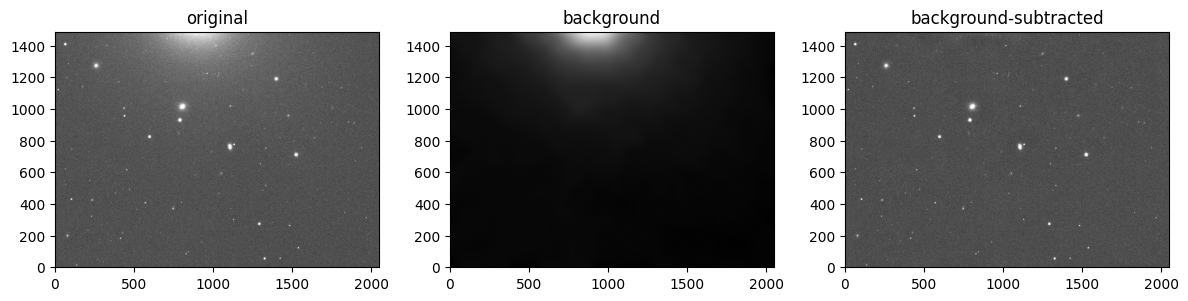

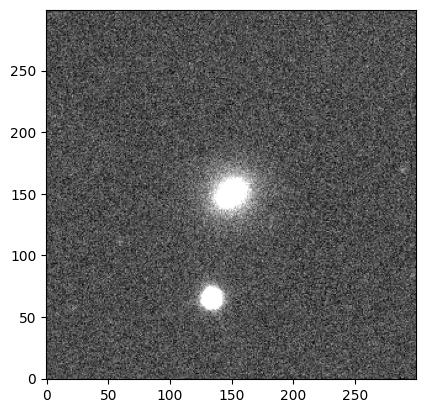

In [77]:
import sep 

data = img.copy()
s_bkg = sep.Background(data, bw=64, bh=64, fw=3, fh=3)
s_bkg_sub = data - s_bkg.back()
s_bkg_rms = s_bkg.rms()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(data, origin='lower', cmap='gray', norm=norm); plt.title('original')
plt.subplot(1,3,2); plt.imshow(s_bkg.back(), origin='lower', cmap='gray'); plt.title('background')
plt.subplot(1,3,3); plt.imshow(s_bkg_sub, origin='lower', cmap='gray', norm=norm); plt.title('background-subtracted')
plt.tight_layout(); plt.show()

sep_img_zoom = s_bkg_sub[862:1162, 655:955]
plt.figure()
plt.imshow(sep_img_zoom, origin='lower', cmap='gray', norm=norm)
plt.show()


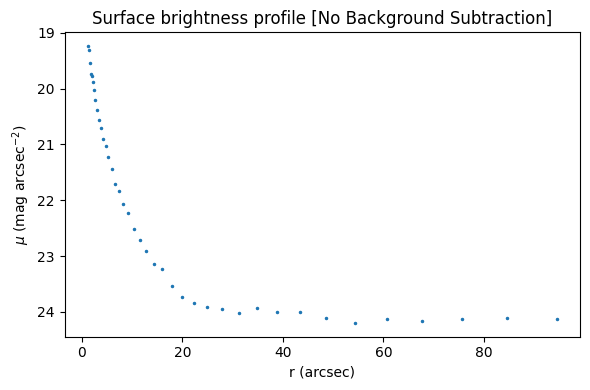

In [80]:
# No Background Subtraction

# manual center & geometry
x0, y0 = 805.0, 1012.0
q = 0.85
theta = 0.0
s = 0.396  # arcsec/pixel

# radial grid (>1", up to ~100" or edge)
h, w = img.shape
r_min_pix = max(3, int(np.ceil(1.0 / s)))
r_edge    = int(min(x0, y0, (w - 1) - x0, (h - 1) - y0))
r_max_pix = max(r_min_pix + 3, min(int(np.floor(100.0 / s)), r_edge - 3))

nbins = 40
edges = np.geomspace(r_min_pix, r_max_pix, nbins + 1)
sma_pix = np.sqrt(edges[:-1] * edges[1:])  # midpoints

# annulus sampling (light trim of top 5% to suppress stars)
ints = []
for a_in, a_out in zip(edges[:-1], edges[1:]):
    ann = EllipticalAnnulus(
    (x0, y0),
    a_in=a_in, a_out=a_out,
    b_in=q*a_in, b_out=q*a_out,
    theta=theta
)
    m = ann.to_mask(method='center')
    m = m[0] if isinstance(m, list) else m
    cut = m.cutout(img)
    if cut is None:
        ints.append(np.nan); continue
    vals = cut[m.data > 0]
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints.append(np.nan); continue
    hi = np.nanpercentile(vals, 95.0)
    ints.append(np.nanmedian(vals[vals <= hi]))

ints = np.asarray(ints, float)
good = np.isfinite(ints) & (ints > 0)
r_arcsec = sma_pix[good] * s

# convert to mu (mag/arcsec^2); replace zeropoint as needed
I_as2 = (ints[good]) / (s**2)
mu = 22.5 - 2.5*np.log10(I_as2)

plt.figure(figsize=(6,4))
plt.plot(r_arcsec, mu, '.', ms=3)
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)'); plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Surface brightness profile [No Background Subtraction]')
plt.tight_layout(); plt.show()

### Sérsic Photometric Quantities

The Sérsic intensity profile is defined as:

\[
I(r) = I_e \, \exp \left\{ -b_n \left[ \left(\frac{r}{R_e}\right)^{1/n} - 1 \right] \right\},
\]

where  
- \( I_e \) is the intensity at the effective radius \(R_e\),  
- \( n \) is the Sérsic index,  
- \( b_n \) is a constant that depends on \(n\),  
- \( R_e \) is the effective radius (half-light radius).  

---

**1. Effective surface brightness**

\[
\mu_e = ZP - 2.5 \, \log_{10}(I_e)
\]

where \(ZP\) is the photometric zeropoint in magnitudes.

---

**2. Effective radius in arcseconds and kiloparsecs**

Convert to physical scale using the galaxy distance \(D\) (in parsecs):

\[
R_e \; [\mathrm{kpc}] = R_e \; [\mathrm{arcsec}] \times \frac{D \cdot \pi}{180 \times 3600} \times \frac{1}{1000}.
\]

---

**3. Total flux of a Sérsic profile**

The integrated flux (excluding sky) is:

\[
F_{\mathrm{tot}} = 2 \pi \, I_e \, R_e^2 \, n \, e^{b_n} \, b_n^{-2n} \, \Gamma(2n),
\]

where \(\Gamma\) is the gamma function.

---

**4. Apparent and absolute magnitudes**

\[
m_{\mathrm{tot}} = ZP - 2.5 \, \log_{10}(F_{\mathrm{tot}}),
\]

\[
M = m_{\mathrm{tot}} - 5 \log_{10} \left( \frac{D}{10 \, \mathrm{pc}} \right).
\]

---

**5. Central surface brightness**

The central intensity is

\[
I(0) = I_e \, e^{b_n},
\]

which corresponds to a surface brightness of

\[
\mu_0 = ZP - 2.5 \, \log_{10}(I(0)).
\]


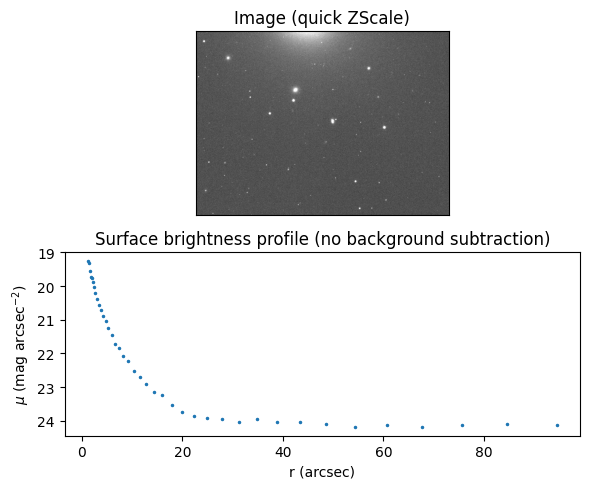

Sérsic fit (no background subtraction):
  n     = 3.572 ± 0.928
  Re    = 10.107 ± 4.771 arcsec
  mu_e  = 22.516 ± 0.796 mag/arcsec^2
  I_sky = 0.123094 ± 0.145602 (intensity units)


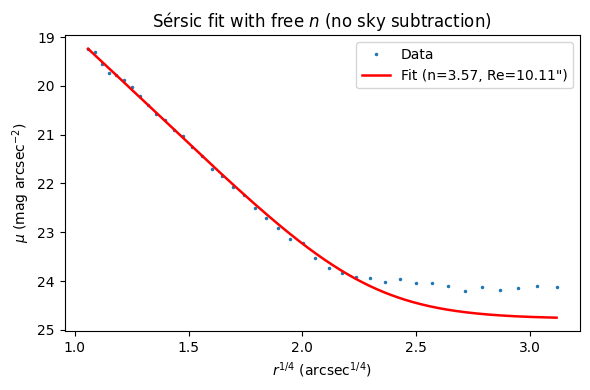

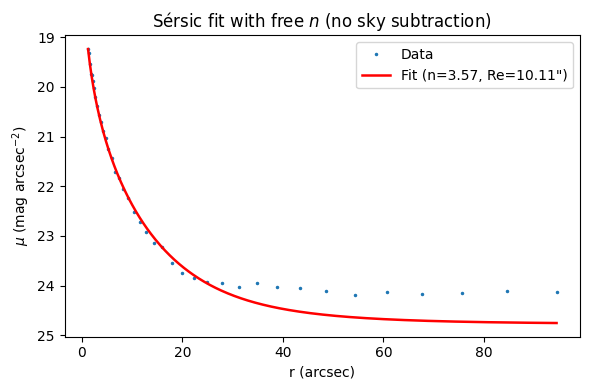


--- Sérsic photometric quantities ---
Effective SB  μ_e     = 22.516 mag/arcsec^2
Effective rad Re      = 10.107 arcsec  = 0.809 kpc  (D = 1.650e+07 pc)
Total flux   F_tot    = 2160.69  (model, sky excluded)
Total magnitude m_tot = 14.164 mag
Absolute mag  M_abs   = -16.924 mag
Central SB    μ_0     = 15.118 mag/arcsec^2


In [98]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ImageNormalize, ZScaleInterval
from astropy.stats import sigma_clip
from photutils.aperture import EllipticalAnnulus
from scipy.optimize import curve_fit
from scipy.special import gamma  # Γ function

# -----------------------
# USER SETTINGS
# -----------------------
# Either load from FITS...
fits_path = "C:/Users/andre/Desktop/Astro/GalacticAstronomy/SurfaceBrightnessProfile/NGC4467.fits"   # <-- set to your file, or set to None to use an in-memory 'img'
ext = 0

# Geometry & calibration
x0, y0 = 805.0, 1012.0      # center (pixels)
q = 0.85                    # axis ratio b/a
theta = 0.0                 # position angle (radians, mathematical; Photutils convention)
s = 0.396                   # arcsec per pixel
ZP = 22.5                   # photometric zeropoint (mag for 1 count per arcsec^2)

# Radial sampling
nbins = 40                  # number of elliptical annuli
clip_sigma = 3.0            # per-annulus sigma-clip
top_trim = 95.0             # trim top X% to suppress stars/cosmic rays

# -----------------------
# LOAD IMAGE
# -----------------------
try:
    img  # if you already defined 'img' upstream, this will succeed
except NameError:
    with fits.open(fits_path, memmap=True) as hdul:
        img = hdul[ext].data.astype(float, copy=False)

# -----------------------
# BUILD ANNULI GRID
# -----------------------
h, w = img.shape
# Start just beyond ~1 arcsec
r_min_pix = max(3, int(np.ceil(1.0 / s)))

# Safe outer limit so BOTH a_out and b_out fit inside the image
xm = min(x0, (w - 1) - x0)
ym = min(y0, (h - 1) - y0)
r_edge_safe = int(min(xm, ym / q))
# Cap outer radius at 100 arcsec
r_cap_pix = int(100.0 / s)
r_max_pix = min(r_edge_safe - 3, r_cap_pix)
r_max_pix = max(r_min_pix + 3, r_max_pix)  # ensure it's bigger than r_min


# Geometric spacing works well for SB profiles
edges = np.geomspace(r_min_pix, r_max_pix, nbins + 1)
sma_pix = np.sqrt(edges[:-1] * edges[1:])  # geometric midpoints (semi-major axis)

# -----------------------
# SAMPLE INTENSITY PER ANNULUS (NO SKY SUBTRACTION)
# -----------------------
ints_pix = []
for a_in, a_out in zip(edges[:-1], edges[1:]):
    ann = EllipticalAnnulus(
        (x0, y0),
        a_in=a_in, a_out=a_out,
        b_in=q * a_in, b_out=q * a_out,  # NOTE: b_out MUST be > b_in
        theta=theta
    )
    m = ann.to_mask(method='center')
    m = m[0] if isinstance(m, list) else m

    cut = m.cutout(img)
    if cut is None:
        ints_pix.append(np.nan)
        continue

    vals = cut[m.data > 0]
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan)
        continue

    # light per-annulus cleaning
    vals = sigma_clip(vals, sigma=clip_sigma, maxiters=3, masked=False)
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan)
        continue

    hi = np.nanpercentile(vals, top_trim)
    vals = vals[vals <= hi]

    ints_pix.append(float(np.nanmedian(vals)))

ints_pix = np.asarray(ints_pix, float)

# Keep only good bins (positive intensities)
good = np.isfinite(ints_pix) & (ints_pix > 0)
sma_pix = sma_pix[good]
ints_pix = ints_pix[good]

# -----------------------
# CONVERT TO SURFACE BRIGHTNESS (mag/arcsec^2)
# -----------------------
r_arcsec = sma_pix * s
I_as2 = ints_pix / (s**2)   # intensity per arcsec^2 (same units as counts, scaled by pixel area)
mu = ZP - 2.5 * np.log10(I_as2)

# -----------------------
# PLOT SB PROFILE (no sky subtraction)
# -----------------------
plt.figure(figsize=(6, 5))
norm = ImageNormalize(img, interval=ZScaleInterval())
plt.subplot(2,1,1)
plt.imshow(img, origin='lower', cmap='gray', norm=norm)
plt.title("Image (quick ZScale)")
plt.xticks([]); plt.yticks([])

plt.subplot(2,1,2)
plt.plot(r_arcsec, mu, '.', ms=3)
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)'); plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Surface brightness profile (no background subtraction)')
plt.tight_layout()
plt.show()

# -----------------------
# SÉRSIC FIT (with free n and additive sky term) IN INTENSITY SPACE
#   I(r) = I_e * exp{ -b_n [ (r/Re)^(1/n) - 1 ] } + I_sky
# -----------------------
def b_n(n):
    # good for ~0.5 < n < 10
    return 2*n - 1.0/3.0 + 4.0/(405.0*n) + 46.0/(25515.0*n**2)

def sersic_I(r, Ie, Re, n, Isky):
    return Ie * np.exp(-b_n(n) * ((r / Re)**(1.0/n) - 1.0)) + Isky

# Data for fit: convert mu -> intensity
I_data = 10**((ZP - mu) / 2.5)

# Initial guesses
r = r_arcsec.copy()
I = I_data.copy()
rmax = r.max()
Ie0   = np.nanpercentile(I, 90)
Re0   = max(0.05, 0.25 * rmax)
n0    = 4.0
Isky0 = np.nanmedian(I[-max(5, len(I)//10):])
p0 = [Ie0, Re0, n0, Isky0]

bounds = (
    [1e-12, 0.05, 0.3, 0.0],   # Ie>0, Re>0.05", n>0.3, Isky>=0
    [np.inf, np.inf, 10.0, np.inf]
)

# modest radial weighting (downweight outskirts a bit)
w = 1.0 / (1.0 + (r / (0.6*rmax))**2)
sigma = np.maximum(1e-12, 1.0 / w)

popt, pcov = curve_fit(
    sersic_I, r, I, p0=p0, bounds=bounds,
    sigma=sigma, absolute_sigma=False, maxfev=20000
)
Ie, Re, n, Isky = popt
perr = np.sqrt(np.diag(pcov)) if np.all(np.isfinite(pcov)) else [np.nan]*4
dIe, dRe, dn, dIsky = perr

mu_e  = ZP - 2.5*np.log10(Ie)
dmu_e = (2.5/np.log(10)) * (dIe/Ie) if (Ie>0 and np.isfinite(dIe)) else np.nan

print("Sérsic fit (no background subtraction):")
print(f"  n     = {n:.3f} ± {dn:.3f}")
print(f"  Re    = {Re:.3f} ± {dRe:.3f} arcsec")
print(f"  mu_e  = {mu_e:.3f} ± {dmu_e:.3f} mag/arcsec^2")
print(f"  I_sky = {Isky:.6g} ± {dIsky:.6g} (intensity units)")

# -----------------------
# OVERLAY FIT
# -----------------------
r_fit = np.linspace(r.min(), r.max(), 500)
I_fit = sersic_I(r_fit, Ie, Re, n, Isky)
I_fit = np.clip(I_fit, 1e-300, None)
mu_fit = ZP - 2.5*np.log10(I_fit)

# Plot μ vs r^{1/4} with fit (classic de Vaucouleurs view)
plt.figure(figsize=(6,4))
plt.plot(r_arcsec**0.25, mu, '.', ms=3, label='Data')
plt.plot(r_fit**0.25, mu_fit, 'r-', lw=1.8, label=f'Fit (n={n:.2f}, Re={Re:.2f}")')
plt.gca().invert_yaxis()
plt.xlabel(r'$r^{1/4}$ (arcsec$^{1/4}$)')
plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Sérsic fit with free $n$ (no sky subtraction)')
plt.legend()
plt.tight_layout()
plt.show()


# --- Plot μ vs r (arcsec) with Sérsic fit overlay ---
r_fit = np.linspace(r.min(), r.max(), 500)
I_fit = sersic_I(r_fit, Ie, Re, n, Isky)
I_fit = np.clip(I_fit, 1e-300, None)  # guard against log(0)
mu_fit = ZP - 2.5 * np.log10(I_fit)

plt.figure(figsize=(6,4))
plt.plot(r_arcsec, mu, '.', ms=3, label='Data')
plt.plot(r_fit, mu_fit, 'r-', lw=1.8,
         label=f'Fit (n={n:.2f}, Re={Re:.2f}")')
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)')
plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Sérsic fit with free $n$ (no sky subtraction)')
plt.legend()
plt.tight_layout()
plt.show()


# --- inputs from your fit ---
# Ie, Re, n, Isky   # (from the fit you ran)
# ZP                # photometric zeropoint used for mu

# --- user-provided distance (parsecs) ---
D_pc = 1.65e7  # <-- set your galaxy distance here (example: 16.5 Mpc = 1.65e7 pc)

# helper: b_n(n)
def b_n(n):
    return 2*n - 1.0/3.0 + 4.0/(405.0*n) + 46.0/(25515.0*n**2)

bn = b_n(n)

# 1) Effective surface brightness (mag/arcsec^2) at Re
mu_e = ZP - 2.5 * np.log10(Ie)

# 2) Effective radius in arcsec and kpc
arcsec_to_pc = D_pc * (np.pi / (180.0 * 3600.0))  # small-angle, 1" in pc
Re_kpc = Re * arcsec_to_pc / 1e3

# 3) Total apparent flux of the galaxy (sky excluded)
#    For I(r) = Ie * exp{-bn[((r/Re)^(1/n)) - 1]}:
#    F_tot = 2π * Ie * Re^2 * n * e^{bn} * bn^{-2n} * Γ(2n)
F_tot = 2.0 * np.pi * Ie * (Re**2) * n * np.exp(bn) * (bn**(-2.0*n)) * gamma(2.0*n)

# Sanity guard (numerics)
F_tot = float(np.clip(F_tot, 1e-300, np.inf))

# 4) Total apparent magnitude (from zeropoint)
m_tot = ZP - 2.5 * np.log10(F_tot)

# 5) Absolute magnitude via distance modulus: M = m - 5 log10(D/10pc)
M_abs = m_tot - 5.0 * np.log10(D_pc / 10.0)

# 6) Central surface brightness (mag/arcsec^2)
#    I(0) = Ie * exp(bn)  ->  mu0 = ZP - 2.5 log10(I0)
I0 = Ie * np.exp(bn)
mu0 = ZP - 2.5 * np.log10(I0)

# --- print nicely ---
print("\n--- Sérsic photometric quantities ---")
print(f"Effective SB  μ_e     = {mu_e:.3f} mag/arcsec^2")
print(f"Effective rad Re      = {Re:.3f} arcsec  = {Re_kpc:.3f} kpc  (D = {D_pc:.3e} pc)")
print(f"Total flux   F_tot    = {F_tot:.6g}  (model, sky excluded)")
print(f"Total magnitude m_tot = {m_tot:.3f} mag")
print(f"Absolute mag  M_abs   = {M_abs:.3f} mag")
print(f"Central SB    μ_0     = {mu0:.3f} mag/arcsec^2")



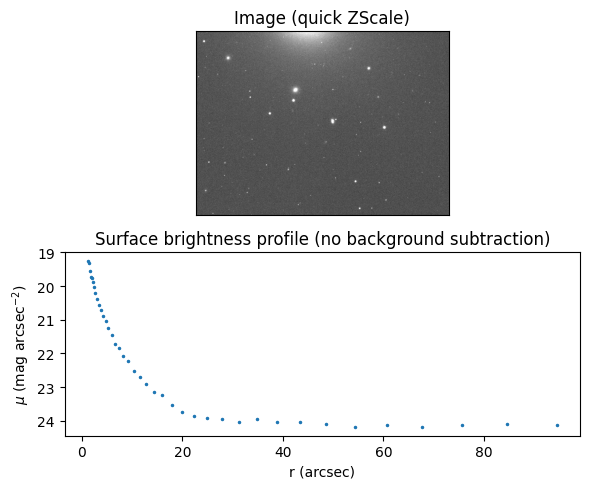

Sérsic fit (no background subtraction):
  n     = 3.572 ± 0.928
  Re    = 10.107 ± 4.771 arcsec
  mu_e  = 22.516 ± 0.796 mag/arcsec^2
  I_sky = 0.123094 ± 0.145602 (intensity units)


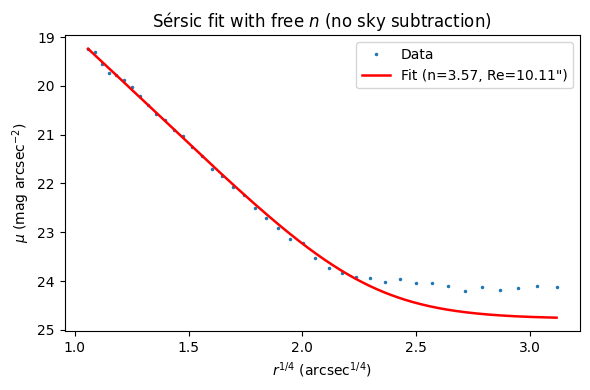

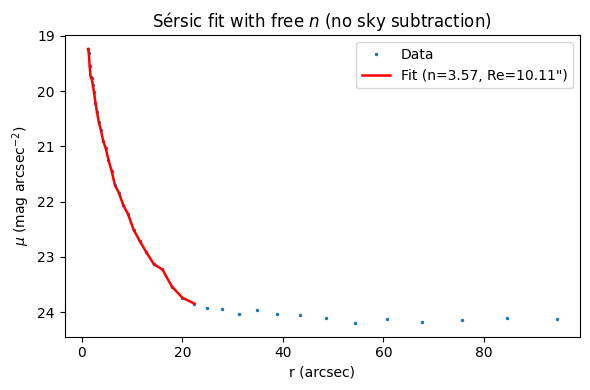


--- Sérsic photometric quantities ---
Effective SB  μ_e     = 22.516 mag/arcsec^2
Effective rad Re      = 10.107 arcsec  = 0.809 kpc  (D = 1.650e+07 pc)
Total flux   F_tot    = 2160.69  (model, sky excluded)
Total magnitude m_tot = 14.164 mag
Absolute mag  M_abs   = -16.924 mag
Central SB    μ_0     = 15.118 mag/arcsec^2


In [100]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ImageNormalize, ZScaleInterval
from astropy.stats import sigma_clip
from photutils.aperture import EllipticalAnnulus
from scipy.optimize import curve_fit
from scipy.special import gamma  # Γ function

# -----------------------
# USER SETTINGS
# -----------------------
# Either load from FITS...
fits_path = "C:/Users/andre/Desktop/Astro/GalacticAstronomy/SurfaceBrightnessProfile/NGC4467.fits"   # <-- set to your file, or set to None to use an in-memory 'img'
ext = 0

# Geometry & calibration
x0, y0 = 805.0, 1012.0      # center (pixels)
q = 0.85                    # axis ratio b/a
theta = 0.0                 # position angle (radians, mathematical; Photutils convention)
s = 0.396                   # arcsec per pixel
ZP = 22.5                   # photometric zeropoint (mag for 1 count per arcsec^2)

# Radial sampling
nbins = 40                  # number of elliptical annuli
clip_sigma = 3.0            # per-annulus sigma-clip
top_trim = 95.0             # trim top X% to suppress stars/cosmic rays

# -----------------------
# LOAD IMAGE
# -----------------------
try:
    img  # if you already defined 'img' upstream, this will succeed
except NameError:
    with fits.open(fits_path, memmap=True) as hdul:
        img = hdul[ext].data.astype(float, copy=False)

# -----------------------
# BUILD ANNULI GRID
# -----------------------
h, w = img.shape
# Start just beyond ~1 arcsec
r_min_pix = max(3, int(np.ceil(1.0 / s)))

# Safe outer limit so BOTH a_out and b_out fit inside the image
xm = min(x0, (w - 1) - x0)
ym = min(y0, (h - 1) - y0)
r_edge_safe = int(min(xm, ym / q))
# Cap outer radius at 100 arcsec
r_cap_pix = int(100.0 / s)
r_max_pix = min(r_edge_safe - 3, r_cap_pix)
r_max_pix = max(r_min_pix + 3, r_max_pix)  # ensure it's bigger than r_min


# Geometric spacing works well for SB profiles
edges = np.geomspace(r_min_pix, r_max_pix, nbins + 1)
sma_pix = np.sqrt(edges[:-1] * edges[1:])  # geometric midpoints (semi-major axis)

# -----------------------
# SAMPLE INTENSITY PER ANNULUS (NO SKY SUBTRACTION)
# -----------------------
ints_pix = []
for a_in, a_out in zip(edges[:-1], edges[1:]):
    ann = EllipticalAnnulus(
        (x0, y0),
        a_in=a_in, a_out=a_out,
        b_in=q * a_in, b_out=q * a_out,  # NOTE: b_out MUST be > b_in
        theta=theta
    )
    m = ann.to_mask(method='center')
    m = m[0] if isinstance(m, list) else m

    cut = m.cutout(img)
    if cut is None:
        ints_pix.append(np.nan)
        continue

    vals = cut[m.data > 0]
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan)
        continue

    # light per-annulus cleaning
    vals = sigma_clip(vals, sigma=clip_sigma, maxiters=3, masked=False)
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan)
        continue

    hi = np.nanpercentile(vals, top_trim)
    vals = vals[vals <= hi]

    ints_pix.append(float(np.nanmedian(vals)))

ints_pix = np.asarray(ints_pix, float)

# Keep only good bins (positive intensities)
good = np.isfinite(ints_pix) & (ints_pix > 0)
sma_pix = sma_pix[good]
ints_pix = ints_pix[good]

# -----------------------
# CONVERT TO SURFACE BRIGHTNESS (mag/arcsec^2)
# -----------------------
r_arcsec = sma_pix * s
I_as2 = ints_pix / (s**2)   # intensity per arcsec^2 (same units as counts, scaled by pixel area)
mu = ZP - 2.5 * np.log10(I_as2)

# -----------------------
# PLOT SB PROFILE (no sky subtraction)
# -----------------------
plt.figure(figsize=(6, 5))
norm = ImageNormalize(img, interval=ZScaleInterval())
plt.subplot(2,1,1)
plt.imshow(img, origin='lower', cmap='gray', norm=norm)
plt.title("Image (quick ZScale)")
plt.xticks([]); plt.yticks([])

plt.subplot(2,1,2)
plt.plot(r_arcsec, mu, '.', ms=3)
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)'); plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Surface brightness profile (no background subtraction)')
plt.tight_layout()
plt.show()

# -----------------------
# SÉRSIC FIT (with free n and additive sky term) IN INTENSITY SPACE
#   I(r) = I_e * exp{ -b_n [ (r/Re)^(1/n) - 1 ] } + I_sky
# -----------------------
def b_n(n):
    # good for ~0.5 < n < 10
    return 2*n - 1.0/3.0 + 4.0/(405.0*n) + 46.0/(25515.0*n**2)

def sersic_I(r, Ie, Re, n, Isky):
    return Ie * np.exp(-b_n(n) * ((r / Re)**(1.0/n) - 1.0)) + Isky

# Data for fit: convert mu -> intensity
I_data = 10**((ZP - mu) / 2.5)

# Initial guesses
r = r_arcsec.copy()
I = I_data.copy()
rmax = r.max()
Ie0   = np.nanpercentile(I, 90)
Re0   = max(0.05, 0.25 * rmax)
n0    = 4.0
Isky0 = np.nanmedian(I[-max(5, len(I)//10):])
p0 = [Ie0, Re0, n0, Isky0]

bounds = (
    [1e-12, 0.05, 0.3, 0.0],   # Ie>0, Re>0.05", n>0.3, Isky>=0
    [np.inf, np.inf, 10.0, np.inf]
)

# modest radial weighting (downweight outskirts a bit)
w = 1.0 / (1.0 + (r / (0.6*rmax))**2)
sigma = np.maximum(1e-12, 1.0 / w)

popt, pcov = curve_fit(
    sersic_I, r, I, p0=p0, bounds=bounds,
    sigma=sigma, absolute_sigma=False, maxfev=20000
)
Ie, Re, n, Isky = popt
perr = np.sqrt(np.diag(pcov)) if np.all(np.isfinite(pcov)) else [np.nan]*4
dIe, dRe, dn, dIsky = perr

mu_e  = ZP - 2.5*np.log10(Ie)
dmu_e = (2.5/np.log(10)) * (dIe/Ie) if (Ie>0 and np.isfinite(dIe)) else np.nan

print("Sérsic fit (no background subtraction):")
print(f"  n     = {n:.3f} ± {dn:.3f}")
print(f"  Re    = {Re:.3f} ± {dRe:.3f} arcsec")
print(f"  mu_e  = {mu_e:.3f} ± {dmu_e:.3f} mag/arcsec^2")
print(f"  I_sky = {Isky:.6g} ± {dIsky:.6g} (intensity units)")

# -----------------------
# OVERLAY FIT
# -----------------------
r_fit = np.linspace(r.min(), r.max(), 500)
I_fit = sersic_I(r_fit, Ie, Re, n, Isky)
I_fit = np.clip(I_fit, 1e-300, None)
mu_fit = ZP - 2.5*np.log10(I_fit)

# Plot μ vs r^{1/4} with fit (classic de Vaucouleurs view)
plt.figure(figsize=(6,4))
plt.plot(r_arcsec**0.25, mu, '.', ms=3, label='Data')
plt.plot(r_fit**0.25, mu_fit, 'r-', lw=1.8, label=f'Fit (n={n:.2f}, Re={Re:.2f}")')
plt.gca().invert_yaxis()
plt.xlabel(r'$r^{1/4}$ (arcsec$^{1/4}$)')
plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Sérsic fit with free $n$ (no sky subtraction)')
plt.legend()
plt.tight_layout()
plt.show()


rmin, rmax = 0.87, 23.88     # arcsec, from the paper
sel = (r_arcsec >= rmin) & (r_arcsec <= rmax)
r_fitpts = r_arcsec[sel]; mu_fitpts = mu[sel]


# --- Plot μ vs r (arcsec) with Sérsic fit overlay ---
r_fit = np.linspace(r.min(), r.max(), 500)
I_fit = sersic_I(r_fit, Ie, Re, n, Isky)
I_fit = np.clip(I_fit, 1e-300, None)  # guard against log(0)
mu_fit = ZP - 2.5 * np.log10(I_fit)

plt.figure(figsize=(6,4))
plt.plot(r_arcsec, mu, '.', ms=3, label='Data')
plt.plot(r_fitpts, mu_fitpts, 'r-', lw=1.8,
         label=f'Fit (n={n:.2f}, Re={Re:.2f}")')
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)')
plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Sérsic fit with free $n$ (no sky subtraction)')
plt.legend()
plt.tight_layout()
plt.show()


# --- inputs from your fit ---
# Ie, Re, n, Isky   # (from the fit you ran)
# ZP                # photometric zeropoint used for mu

# --- user-provided distance (parsecs) ---
D_pc = 1.65e7  # <-- set your galaxy distance here (example: 16.5 Mpc = 1.65e7 pc)

# helper: b_n(n)
def b_n(n):
    return 2*n - 1.0/3.0 + 4.0/(405.0*n) + 46.0/(25515.0*n**2)

bn = b_n(n)

# 1) Effective surface brightness (mag/arcsec^2) at Re
mu_e = ZP - 2.5 * np.log10(Ie)

# 2) Effective radius in arcsec and kpc
arcsec_to_pc = D_pc * (np.pi / (180.0 * 3600.0))  # small-angle, 1" in pc
Re_kpc = Re * arcsec_to_pc / 1e3

# 3) Total apparent flux of the galaxy (sky excluded)
#    For I(r) = Ie * exp{-bn[((r/Re)^(1/n)) - 1]}:
#    F_tot = 2π * Ie * Re^2 * n * e^{bn} * bn^{-2n} * Γ(2n)
F_tot = 2.0 * np.pi * Ie * (Re**2) * n * np.exp(bn) * (bn**(-2.0*n)) * gamma(2.0*n)

# Sanity guard (numerics)
F_tot = float(np.clip(F_tot, 1e-300, np.inf))

# 4) Total apparent magnitude (from zeropoint)
m_tot = ZP - 2.5 * np.log10(F_tot)

# 5) Absolute magnitude via distance modulus: M = m - 5 log10(D/10pc)
M_abs = m_tot - 5.0 * np.log10(D_pc / 10.0)

# 6) Central surface brightness (mag/arcsec^2)
#    I(0) = Ie * exp(bn)  ->  mu0 = ZP - 2.5 log10(I0)
I0 = Ie * np.exp(bn)
mu0 = ZP - 2.5 * np.log10(I0)

# --- print nicely ---
print("\n--- Sérsic photometric quantities ---")
print(f"Effective SB  μ_e     = {mu_e:.3f} mag/arcsec^2")
print(f"Effective rad Re      = {Re:.3f} arcsec  = {Re_kpc:.3f} kpc  (D = {D_pc:.3e} pc)")
print(f"Total flux   F_tot    = {F_tot:.6g}  (model, sky excluded)")
print(f"Total magnitude m_tot = {m_tot:.3f} mag")
print(f"Absolute mag  M_abs   = {M_abs:.3f} mag")
print(f"Central SB    μ_0     = {mu0:.3f} mag/arcsec^2")



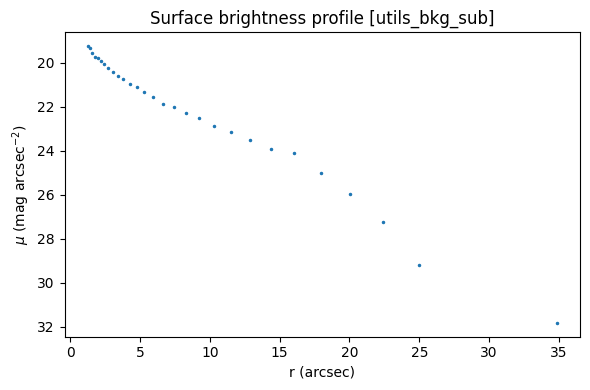

In [81]:
# Utils

# manual center & geometry
x0, y0 = 805.0, 1012.0
q = 0.85
theta = 0.0
s = 0.396  # arcsec/pixel

# radial grid (>1", up to ~100" or edge)
h, w = bkg_sub_p.shape
r_min_pix = max(3, int(np.ceil(1.0 / s)))
r_edge    = int(min(x0, y0, (w - 1) - x0, (h - 1) - y0))
r_max_pix = max(r_min_pix + 3, min(int(np.floor(100.0 / s)), r_edge - 3))

nbins = 40
edges = np.geomspace(r_min_pix, r_max_pix, nbins + 1)
sma_pix = np.sqrt(edges[:-1] * edges[1:])  # midpoints

# annulus sampling (light trim of top 5% to suppress stars)
ints = []
for a_in, a_out in zip(edges[:-1], edges[1:]):
    ann = EllipticalAnnulus(
    (x0, y0),
    a_in=a_in, a_out=a_out,
    b_in=q*a_in, b_out=q*a_out,
    theta=theta
)
    m = ann.to_mask(method='center')
    m = m[0] if isinstance(m, list) else m
    cut = m.cutout(bkg_sub_p)
    if cut is None:
        ints.append(np.nan); continue
    vals = cut[m.data > 0]
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints.append(np.nan); continue
    hi = np.nanpercentile(vals, 95.0)
    ints.append(np.nanmedian(vals[vals <= hi]))

ints = np.asarray(ints, float)
good = np.isfinite(ints) & (ints > 0)
r_arcsec_1 = sma_pix[good] * s

# convert to mu (mag/arcsec^2); replace zeropoint as needed
I_as2 = (ints[good]) / (s**2)
mu = 22.5 - 2.5*np.log10(I_as2)

plt.figure(figsize=(6,4))
plt.plot(r_arcsec_1, mu, '.', ms=3)
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)'); plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Surface brightness profile [utils_bkg_sub]')
plt.tight_layout(); plt.show()

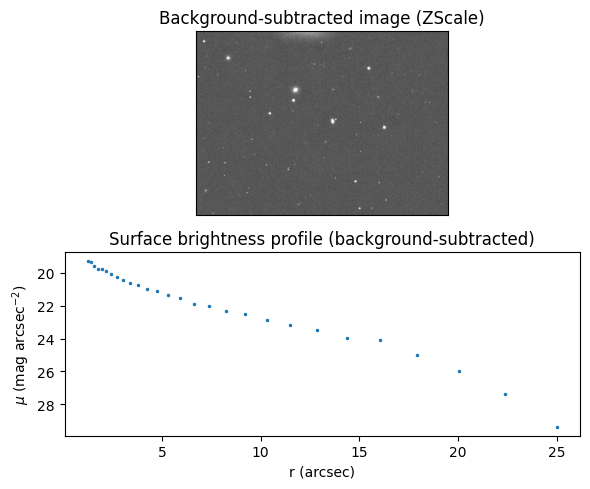

Sérsic fit on background-subtracted profile:
  n     = 3.255 ± 0.812
  Re    = 8.181 ± 2.957 arcsec
  mu_e  = 22.191 ± 0.639 mag/arcsec^2


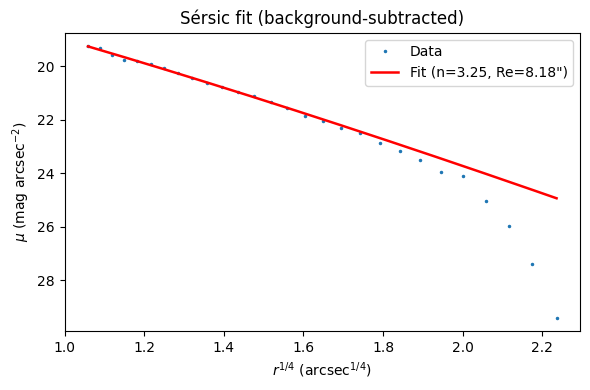

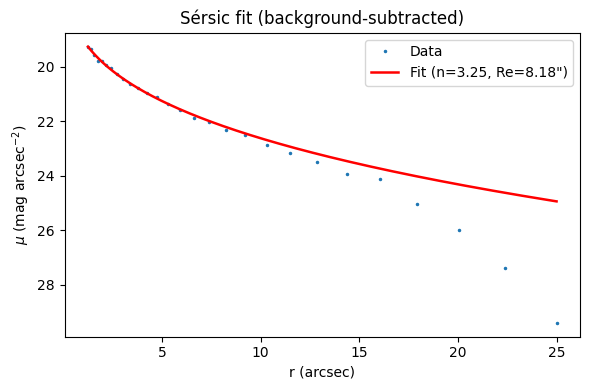


--- Sérsic photometric quantities (sky-subtracted) ---
Effective SB  μ_e     = 22.191 mag/arcsec^2
Effective rad Re      = 8.181 arcsec  = 0.654 kpc  (D = 1.650e+07 pc)
Total flux   F_tot    = 1826.59  (Sérsic component)
Total magnitude m_tot = 14.346 mag
Absolute mag  M_abs   = -16.742 mag
Central SB    μ_0     = 15.482 mag/arcsec^2


In [97]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ImageNormalize, ZScaleInterval
from astropy.stats import sigma_clip
from photutils.aperture import EllipticalAnnulus
from scipy.optimize import curve_fit
from scipy.special import gamma  # Γ function

# -----------------------
# USER SETTINGS
# -----------------------
# Use an in-memory background-subtracted image 'img_sub' if available.
# Otherwise, set fits_path to a FITS that is ALREADY background-subtracted.
fits_path = None  # e.g., "my_image_bgsub.fits" or keep None to use img_sub
ext = 0

# Geometry & calibration
x0, y0 = 805.0, 1012.0      # center (pixels)
q = 0.85                    # axis ratio b/a
theta = 0.0                 # position angle (radians; Photutils convention)
s = 0.396                   # arcsec per pixel
ZP = 22.5                   # zeropoint (mag for 1 count per arcsec^2)

# Radial sampling
nbins = 40                  # number of elliptical annuli
clip_sigma = 3.0            # per-annulus sigma-clip (within each annulus)
top_trim = 95.0             # trim top X% to suppress stars/cosmic rays

# -----------------------
# LOAD BACKGROUND-SUBTRACTED IMAGE
# -----------------------
try:
    bkg_sub_p  # from previous cell
except NameError:
    if fits_path is None:
        raise RuntimeError("Provide an in-memory 'img_sub' or set 'fits_path' to a bg-subtracted FITS.")
    with fits.open(fits_path, memmap=True) as hdul:
        img_sub = hdul[ext].data.astype(float, copy=False)

# -----------------------
# BUILD ANNULI GRID
# -----------------------
h, w = bkg_sub_p.shape
r_min_pix = max(3, int(np.ceil(1.0 / s)))  # start just beyond ~1"
xm = min(x0, (w - 1) - x0)
ym = min(y0, (h - 1) - y0)
r_edge_safe = int(min(xm, ym / q))         # ensure both a_out and b_out fit
# Cap outer radius at 100 arcsec
r_cap_pix = int(100.0 / s)
r_max_pix = min(r_edge_safe - 3, r_cap_pix)
r_max_pix = max(r_min_pix + 3, r_max_pix)  # ensure it's bigger than r_min


edges = np.geomspace(r_min_pix, r_max_pix, nbins + 1)
sma_pix = np.sqrt(edges[:-1] * edges[1:])  # geometric midpoints

# -----------------------
# SAMPLE INTENSITY PER ANNULUS (SKY IS ALREADY REMOVED)
# -----------------------
ints_pix = []
for a_in, a_out in zip(edges[:-1], edges[1:]):
    ann = EllipticalAnnulus(
        (x0, y0),
        a_in=a_in, a_out=a_out,
        b_in=q * a_in, b_out=q * a_out,
        theta=theta
    )
    m = ann.to_mask(method='center')
    m = m[0] if isinstance(m, list) else m

    cut = m.cutout(bkg_sub_p)
    if cut is None:
        ints_pix.append(np.nan)
        continue

    vals = cut[m.data > 0]
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan)
        continue

    vals = sigma_clip(vals, sigma=clip_sigma, maxiters=3, masked=False)
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan)
        continue

    hi = np.nanpercentile(vals, top_trim)
    vals = vals[vals <= hi]

    # median intensity per annulus (counts per pixel)
    ints_pix.append(float(np.nanmedian(vals)))

ints_pix = np.asarray(ints_pix, float)

# keep only good, positive surface brightness points
good = np.isfinite(ints_pix) & (ints_pix > 0)
sma_pix = sma_pix[good]
ints_pix = ints_pix[good]

# -----------------------
# CONVERT TO μ (mag/arcsec^2)
# -----------------------
r_arcsec = sma_pix * s
I_as2 = ints_pix / (s**2)                 # intensity per arcsec^2
mu = ZP - 2.5 * np.log10(I_as2)

# -----------------------
# QUICK LOOK
# -----------------------
plt.figure(figsize=(6, 5))
norm = ImageNormalize(bkg_sub_p, interval=ZScaleInterval())
plt.subplot(2,1,1)
plt.imshow(bkg_sub_p, origin='lower', cmap='gray', norm=norm)
plt.title("Background-subtracted image (ZScale)")
plt.xticks([]); plt.yticks([])

plt.subplot(2,1,2)
plt.plot(r_arcsec, mu, '.', ms=3)
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)'); plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Surface brightness profile (background-subtracted)')
plt.tight_layout()
plt.show()

# -----------------------
# SÉRSIC FIT (FREE n) — NO SKY TERM
#   I(r) = I_e * exp{ -b_n [ (r/Re)^(1/n) - 1 ] }
# Fit is in intensity space; sky already removed.
# -----------------------
def b_n(n):
    return 2*n - 1.0/3.0 + 4.0/(405.0*n) + 46.0/(25515.0*n**2)

def sersic_I_nosky(r, Ie, Re, n):
    return Ie * np.exp(-b_n(n) * ((r / Re)**(1.0/n) - 1.0))

# data for fit
r = r_arcsec.copy()
I = 10**((ZP - mu) / 2.5)  # convert μ -> intensity

# drop any pathological values
m = np.isfinite(r) & np.isfinite(I) & (I > 0)
r, I = r[m], I[m]

# initial guesses
rmax = r.max()
Ie0 = np.nanpercentile(I, 85)
Re0 = max(0.05, 0.25 * rmax)
n0  = 4.0
p0 = [Ie0, Re0, n0]

bounds = (
    [1e-12, 0.05, 0.3],     # Ie>0, Re>0.05", n>0.3
    [np.inf, np.inf, 10.0]
)

# modest radial weighting (downweight outskirts a bit)
w = 1.0 / (1.0 + (r / (0.6*rmax))**2)
sigma = np.maximum(1e-12, 1.0 / w)

popt, pcov = curve_fit(
    sersic_I_nosky, r, I, p0=p0, bounds=bounds,
    sigma=sigma, absolute_sigma=False, maxfev=20000
)
Ie, Re, n = popt
perr = np.sqrt(np.diag(pcov)) if np.all(np.isfinite(pcov)) else [np.nan]*3
dIe, dRe, dn = perr

mu_e  = ZP - 2.5*np.log10(Ie)
dmu_e = (2.5/np.log(10)) * (dIe/Ie) if (Ie>0 and np.isfinite(dIe)) else np.nan

print("Sérsic fit on background-subtracted profile:")
print(f"  n     = {n:.3f} ± {dn:.3f}")
print(f"  Re    = {Re:.3f} ± {dRe:.3f} arcsec")
print(f"  mu_e  = {mu_e:.3f} ± {dmu_e:.3f} mag/arcsec^2")

# -----------------------
# OVERLAY FITS
# -----------------------
r_fit = np.linspace(r.min(), r.max(), 500)
I_fit = sersic_I_nosky(r_fit, Ie, Re, n)
I_fit = np.clip(I_fit, 1e-300, None)
mu_fit = ZP - 2.5*np.log10(I_fit)

# μ vs r^{1/4}
plt.figure(figsize=(6,4))
plt.plot(r_arcsec**0.25, mu, '.', ms=3, label='Data')
plt.plot(r_fit**0.25, mu_fit, 'r-', lw=1.8, label=f'Fit (n={n:.2f}, Re={Re:.2f}")')
plt.gca().invert_yaxis()
plt.xlabel(r'$r^{1/4}$ (arcsec$^{1/4}$)')
plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Sérsic fit (background-subtracted)')
plt.legend()
plt.tight_layout()
plt.show()

# μ vs r
plt.figure(figsize=(6,4))
plt.plot(r_arcsec, mu, '.', ms=3, label='Data')
plt.plot(r_fit, mu_fit, 'r-', lw=1.8, label=f'Fit (n={n:.2f}, Re={Re:.2f}")')
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)')
plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Sérsic fit (background-subtracted)')
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------
# PHOTOMETRIC QUANTITIES (Sérsic only; sky already removed)
# -----------------------
bn = b_n(n)

# Effective SB at Re
mu_e = ZP - 2.5 * np.log10(Ie)

# Effective radius in kpc (requires distance)
D_pc = 1.65e7  # <-- set your galaxy distance in parsecs (e.g., 16.5 Mpc)
arcsec_to_pc = D_pc * (np.pi / (180.0 * 3600.0))  # 1" in pc (small-angle)
Re_kpc = Re * arcsec_to_pc / 1e3

# Total flux (Sérsic component only)
F_tot = 2.0 * np.pi * Ie * (Re**2) * n * np.exp(bn) * (bn**(-2.0*n)) * gamma(2.0*n)
F_tot = float(np.clip(F_tot, 1e-300, np.inf))

# Magnitudes
m_tot = ZP - 2.5 * np.log10(F_tot)
M_abs = m_tot - 5.0 * np.log10(D_pc / 10.0)

# Central surface brightness
I0 = Ie * np.exp(bn)
mu0 = ZP - 2.5 * np.log10(I0)

print("\n--- Sérsic photometric quantities (sky-subtracted) ---")
print(f"Effective SB  μ_e     = {mu_e:.3f} mag/arcsec^2")
print(f"Effective rad Re      = {Re:.3f} arcsec  = {Re_kpc:.3f} kpc  (D = {D_pc:.3e} pc)")
print(f"Total flux   F_tot    = {F_tot:.6g}  (Sérsic component)")
print(f"Total magnitude m_tot = {m_tot:.3f} mag")
print(f"Absolute mag  M_abs   = {M_abs:.3f} mag")
print(f"Central SB    μ_0     = {mu0:.3f} mag/arcsec^2")


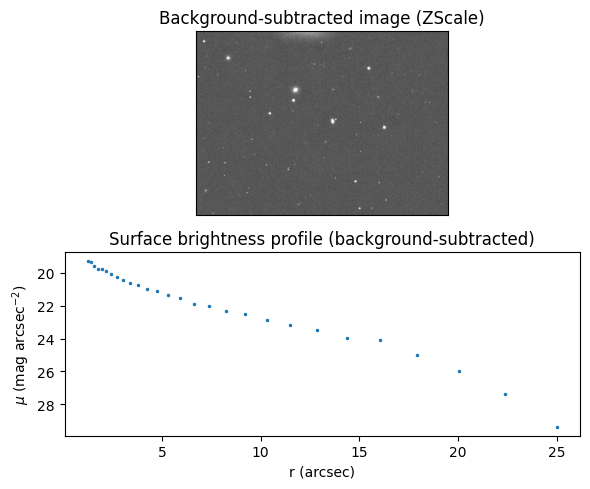

Sérsic fit on background-subtracted profile:
  n     = 3.255 ± 0.812
  Re    = 8.181 ± 2.957 arcsec
  mu_e  = 22.191 ± 0.639 mag/arcsec^2


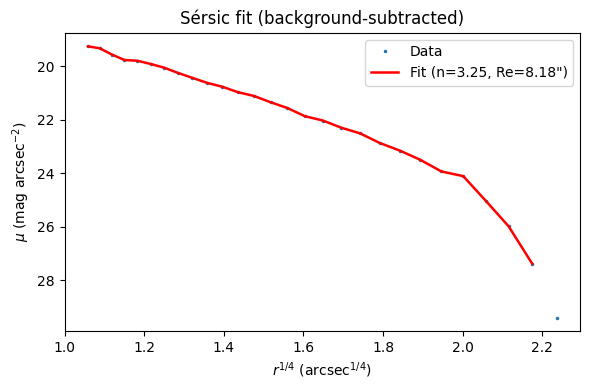

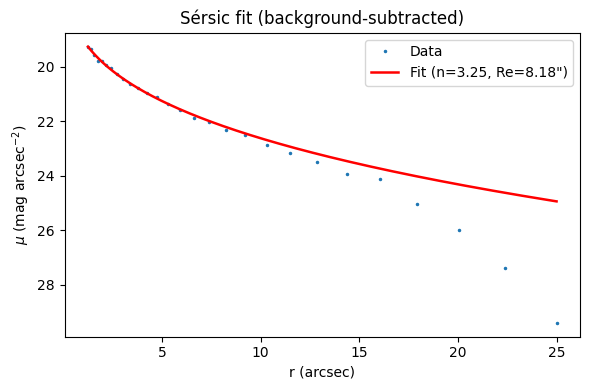


--- Sérsic photometric quantities (sky-subtracted) ---
Effective SB  μ_e     = 22.191 mag/arcsec^2
Effective rad Re      = 8.181 arcsec  = 0.654 kpc  (D = 1.650e+07 pc)
Total flux   F_tot    = 1826.59  (Sérsic component)
Total magnitude m_tot = 14.346 mag
Absolute mag  M_abs   = -16.742 mag
Central SB    μ_0     = 15.482 mag/arcsec^2


In [101]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ImageNormalize, ZScaleInterval
from astropy.stats import sigma_clip
from photutils.aperture import EllipticalAnnulus
from scipy.optimize import curve_fit
from scipy.special import gamma  # Γ function

# -----------------------
# USER SETTINGS
# -----------------------
# Use an in-memory background-subtracted image 'img_sub' if available.
# Otherwise, set fits_path to a FITS that is ALREADY background-subtracted.
fits_path = None  # e.g., "my_image_bgsub.fits" or keep None to use img_sub
ext = 0

# Geometry & calibration
x0, y0 = 805.0, 1012.0      # center (pixels)
q = 0.85                    # axis ratio b/a
theta = 0.0                 # position angle (radians; Photutils convention)
s = 0.396                   # arcsec per pixel
ZP = 22.5                   # zeropoint (mag for 1 count per arcsec^2)

# Radial sampling
nbins = 40                  # number of elliptical annuli
clip_sigma = 3.0            # per-annulus sigma-clip (within each annulus)
top_trim = 95.0             # trim top X% to suppress stars/cosmic rays

# -----------------------
# LOAD BACKGROUND-SUBTRACTED IMAGE
# -----------------------
try:
    bkg_sub_p  # from previous cell
except NameError:
    if fits_path is None:
        raise RuntimeError("Provide an in-memory 'img_sub' or set 'fits_path' to a bg-subtracted FITS.")
    with fits.open(fits_path, memmap=True) as hdul:
        img_sub = hdul[ext].data.astype(float, copy=False)

# -----------------------
# BUILD ANNULI GRID
# -----------------------
h, w = bkg_sub_p.shape
r_min_pix = max(3, int(np.ceil(1.0 / s)))  # start just beyond ~1"
xm = min(x0, (w - 1) - x0)
ym = min(y0, (h - 1) - y0)
r_edge_safe = int(min(xm, ym / q))         # ensure both a_out and b_out fit
# Cap outer radius at 100 arcsec
r_cap_pix = int(100.0 / s)
r_max_pix = min(r_edge_safe - 3, r_cap_pix)
r_max_pix = max(r_min_pix + 3, r_max_pix)  # ensure it's bigger than r_min


edges = np.geomspace(r_min_pix, r_max_pix, nbins + 1)
sma_pix = np.sqrt(edges[:-1] * edges[1:])  # geometric midpoints

# -----------------------
# SAMPLE INTENSITY PER ANNULUS (SKY IS ALREADY REMOVED)
# -----------------------
ints_pix = []
for a_in, a_out in zip(edges[:-1], edges[1:]):
    ann = EllipticalAnnulus(
        (x0, y0),
        a_in=a_in, a_out=a_out,
        b_in=q * a_in, b_out=q * a_out,
        theta=theta
    )
    m = ann.to_mask(method='center')
    m = m[0] if isinstance(m, list) else m

    cut = m.cutout(bkg_sub_p)
    if cut is None:
        ints_pix.append(np.nan)
        continue

    vals = cut[m.data > 0]
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan)
        continue

    vals = sigma_clip(vals, sigma=clip_sigma, maxiters=3, masked=False)
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan)
        continue

    hi = np.nanpercentile(vals, top_trim)
    vals = vals[vals <= hi]

    # median intensity per annulus (counts per pixel)
    ints_pix.append(float(np.nanmedian(vals)))

ints_pix = np.asarray(ints_pix, float)

# keep only good, positive surface brightness points
good = np.isfinite(ints_pix) & (ints_pix > 0)
sma_pix = sma_pix[good]
ints_pix = ints_pix[good]

# -----------------------
# CONVERT TO μ (mag/arcsec^2)
# -----------------------
r_arcsec = sma_pix * s
I_as2 = ints_pix / (s**2)                 # intensity per arcsec^2
mu = ZP - 2.5 * np.log10(I_as2)

# -----------------------
# QUICK LOOK
# -----------------------
plt.figure(figsize=(6, 5))
norm = ImageNormalize(bkg_sub_p, interval=ZScaleInterval())
plt.subplot(2,1,1)
plt.imshow(bkg_sub_p, origin='lower', cmap='gray', norm=norm)
plt.title("Background-subtracted image (ZScale)")
plt.xticks([]); plt.yticks([])

plt.subplot(2,1,2)
plt.plot(r_arcsec, mu, '.', ms=3)
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)'); plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Surface brightness profile (background-subtracted)')
plt.tight_layout()
plt.show()

# -----------------------
# SÉRSIC FIT (FREE n) — NO SKY TERM
#   I(r) = I_e * exp{ -b_n [ (r/Re)^(1/n) - 1 ] }
# Fit is in intensity space; sky already removed.
# -----------------------
def b_n(n):
    return 2*n - 1.0/3.0 + 4.0/(405.0*n) + 46.0/(25515.0*n**2)

def sersic_I_nosky(r, Ie, Re, n):
    return Ie * np.exp(-b_n(n) * ((r / Re)**(1.0/n) - 1.0))

# data for fit
r = r_arcsec.copy()
I = 10**((ZP - mu) / 2.5)  # convert μ -> intensity

# drop any pathological values
m = np.isfinite(r) & np.isfinite(I) & (I > 0)
r, I = r[m], I[m]

# initial guesses
rmax = r.max()
Ie0 = np.nanpercentile(I, 85)
Re0 = max(0.05, 0.25 * rmax)
n0  = 4.0
p0 = [Ie0, Re0, n0]

bounds = (
    [1e-12, 0.05, 0.3],     # Ie>0, Re>0.05", n>0.3
    [np.inf, np.inf, 10.0]
)

# modest radial weighting (downweight outskirts a bit)
w = 1.0 / (1.0 + (r / (0.6*rmax))**2)
sigma = np.maximum(1e-12, 1.0 / w)

popt, pcov = curve_fit(
    sersic_I_nosky, r, I, p0=p0, bounds=bounds,
    sigma=sigma, absolute_sigma=False, maxfev=20000
)
Ie, Re, n = popt
perr = np.sqrt(np.diag(pcov)) if np.all(np.isfinite(pcov)) else [np.nan]*3
dIe, dRe, dn = perr

mu_e  = ZP - 2.5*np.log10(Ie)
dmu_e = (2.5/np.log(10)) * (dIe/Ie) if (Ie>0 and np.isfinite(dIe)) else np.nan

print("Sérsic fit on background-subtracted profile:")
print(f"  n     = {n:.3f} ± {dn:.3f}")
print(f"  Re    = {Re:.3f} ± {dRe:.3f} arcsec")
print(f"  mu_e  = {mu_e:.3f} ± {dmu_e:.3f} mag/arcsec^2")

# -----------------------
# OVERLAY FITS
# -----------------------
r_fit = np.linspace(r.min(), r.max(), 500)
I_fit = sersic_I_nosky(r_fit, Ie, Re, n)
I_fit = np.clip(I_fit, 1e-300, None)
mu_fit = ZP - 2.5*np.log10(I_fit)

rmin, rmax = 0.87, 23.88     # arcsec, from the paper
sel = (r_arcsec >= rmin) & (r_arcsec <= rmax)
r_fitpts = r_arcsec[sel]; mu_fitpts = mu[sel]


# μ vs r^{1/4}
plt.figure(figsize=(6,4))
plt.plot(r_arcsec**0.25, mu, '.', ms=3, label='Data')
plt.plot(r_fitpts**0.25, mu_fitpts, 'r-', lw=1.8, label=f'Fit (n={n:.2f}, Re={Re:.2f}")')
plt.gca().invert_yaxis()
plt.xlabel(r'$r^{1/4}$ (arcsec$^{1/4}$)')
plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Sérsic fit (background-subtracted)')
plt.legend()
plt.tight_layout()
plt.show()

# μ vs r
plt.figure(figsize=(6,4))
plt.plot(r_arcsec, mu, '.', ms=3, label='Data')
plt.plot(r_fit, mu_fit, 'r-', lw=1.8, label=f'Fit (n={n:.2f}, Re={Re:.2f}")')
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)')
plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Sérsic fit (background-subtracted)')
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------
# PHOTOMETRIC QUANTITIES (Sérsic only; sky already removed)
# -----------------------
bn = b_n(n)

# Effective SB at Re
mu_e = ZP - 2.5 * np.log10(Ie)

# Effective radius in kpc (requires distance)
D_pc = 1.65e7  # <-- set your galaxy distance in parsecs (e.g., 16.5 Mpc)
arcsec_to_pc = D_pc * (np.pi / (180.0 * 3600.0))  # 1" in pc (small-angle)
Re_kpc = Re * arcsec_to_pc / 1e3

# Total flux (Sérsic component only)
F_tot = 2.0 * np.pi * Ie * (Re**2) * n * np.exp(bn) * (bn**(-2.0*n)) * gamma(2.0*n)
F_tot = float(np.clip(F_tot, 1e-300, np.inf))

# Magnitudes
m_tot = ZP - 2.5 * np.log10(F_tot)
M_abs = m_tot - 5.0 * np.log10(D_pc / 10.0)

# Central surface brightness
I0 = Ie * np.exp(bn)
mu0 = ZP - 2.5 * np.log10(I0)

print("\n--- Sérsic photometric quantities (sky-subtracted) ---")
print(f"Effective SB  μ_e     = {mu_e:.3f} mag/arcsec^2")
print(f"Effective rad Re      = {Re:.3f} arcsec  = {Re_kpc:.3f} kpc  (D = {D_pc:.3e} pc)")
print(f"Total flux   F_tot    = {F_tot:.6g}  (Sérsic component)")
print(f"Total magnitude m_tot = {m_tot:.3f} mag")
print(f"Absolute mag  M_abs   = {M_abs:.3f} mag")
print(f"Central SB    μ_0     = {mu0:.3f} mag/arcsec^2")


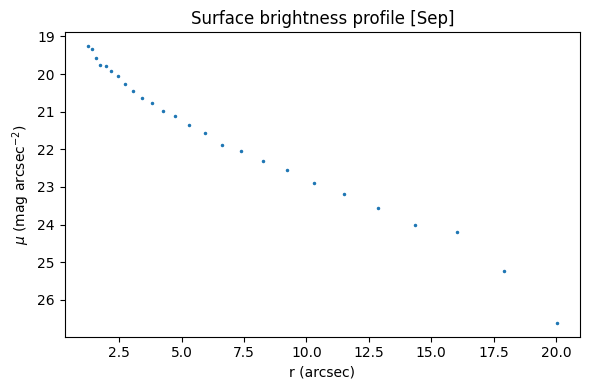

In [83]:
# Sep

# manual center & geometry
x0, y0 = 805.0, 1012.0
q = 0.85
theta = 0.0
s = 0.396  # arcsec/pixel

# radial grid (>1", up to ~100" or edge)
h, w = s_bkg_sub.shape
r_min_pix = max(3, int(np.ceil(1.0 / s)))
r_edge    = int(min(x0, y0, (w - 1) - x0, (h - 1) - y0))
r_max_pix = max(r_min_pix + 3, min(int(np.floor(100.0 / s)), r_edge - 3))

nbins = 40
edges = np.geomspace(r_min_pix, r_max_pix, nbins + 1)
sma_pix = np.sqrt(edges[:-1] * edges[1:])  # midpoints

# annulus sampling (light trim of top 5% to suppress stars)
ints = []
for a_in, a_out in zip(edges[:-1], edges[1:]):
    ann = EllipticalAnnulus(
    (x0, y0),
    a_in=a_in, a_out=a_out,
    b_in=q*a_in, b_out=q*a_out,
    theta=theta
)
    m = ann.to_mask(method='center')
    m = m[0] if isinstance(m, list) else m
    cut = m.cutout(s_bkg_sub)
    if cut is None:
        ints.append(np.nan); continue
    vals = cut[m.data > 0]
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints.append(np.nan); continue
    hi = np.nanpercentile(vals, 95.0)
    ints.append(np.nanmedian(vals[vals <= hi]))

ints = np.asarray(ints, float)
good = np.isfinite(ints) & (ints > 0)
r_arcsec_2 = sma_pix[good] * s

# convert to mu (mag/arcsec^2); replace zeropoint as needed
I_as2 = (ints[good]) / (s**2)
mu = 22.5 - 2.5*np.log10(I_as2)

plt.figure(figsize=(6,4))
plt.plot(r_arcsec_2, mu, '.', ms=3)
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)'); plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Surface brightness profile [Sep]')
plt.tight_layout(); plt.show()

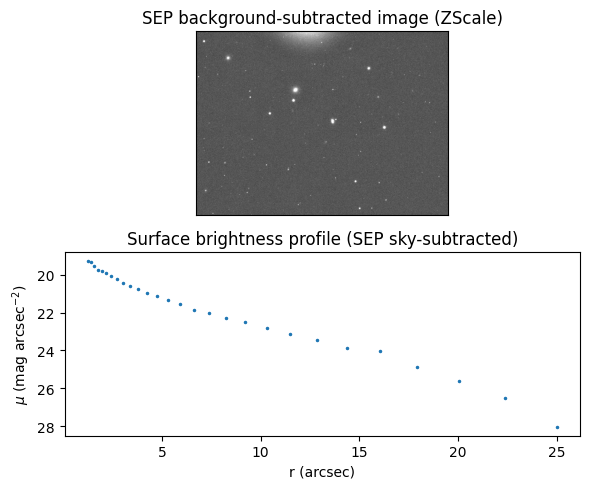

Sérsic fit on SEP background-subtracted profile:
  n     = 3.315 ± 0.837
  Re    = 8.496 ± 3.185 arcsec
  mu_e  = 22.250 ± 0.661 mag/arcsec^2


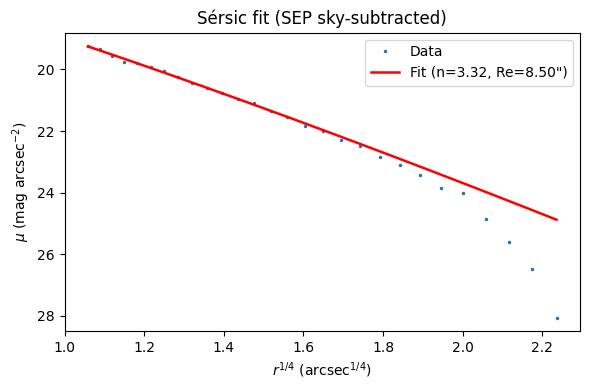

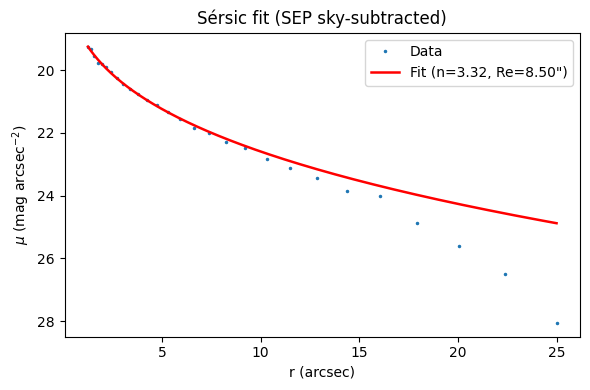


--- Sérsic photometric quantities (SEP sky-subtracted) ---
Effective SB  μ_e     = 22.250 mag/arcsec^2
Effective rad Re      = 8.496 arcsec  = 0.680 kpc  (D = 1.650e+07 pc)
Total flux   F_tot    = 1881.84  (Sérsic component)
Total magnitude m_tot = 14.314 mag
Absolute mag  M_abs   = -16.774 mag
Central SB    μ_0     = 15.410 mag/arcsec^2


In [96]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ImageNormalize, ZScaleInterval
from astropy.stats import sigma_clip
from photutils.aperture import EllipticalAnnulus
from scipy.optimize import curve_fit
from scipy.special import gamma  # Γ function

# -----------------------
# USER SETTINGS
# -----------------------
# Preferred: use in-memory SEP-subtracted image 'img_sub' from earlier cell.
# Alternatively, set fits_path to a FITS that is ALREADY SEP bg-subtracted.
fits_path = "C:/Users/andre/Desktop/Astro/GalacticAstronomy/SurfaceBrightnessProfile/NGC4467.fits"  # e.g., "my_image_sep_bgsub.fits" or keep None to use img_sub
ext = 0

# If you need to redo SEP bg subtraction inside this script, uncomment:
# import sep
# raw_fits_path = "my_image.fits"

# Geometry & calibration
x0, y0 = 805.0, 1012.0      # center (pixels)
q = 0.85                    # axis ratio b/a
theta = 0.0                 # PA in radians (Photutils convention)
s = 0.396                   # arcsec per pixel
ZP = 22.5                   # zeropoint (mag for 1 count per arcsec^2)

# Radial sampling
nbins = 40
clip_sigma = 3.0
top_trim = 95.0

# -----------------------
# LOAD SEP-BACKGROUND–SUBTRACTED IMAGE
# -----------------------
try:
    img_sub  # from an earlier cell: img_sub = img - bkg.back()
except NameError:
    if fits_path is not None:
        with fits.open(fits_path, memmap=True) as hdul:
            img_sub = hdul[ext].data.astype(float, copy=False)
    else:
        raise RuntimeError(
            "Provide in-memory 'img_sub' from SEP subtraction, or set 'fits_path' "
            "to a FITS that is already background-subtracted by SEP."
        )
        # If you want to recompute here, uncomment and set raw_fits_path above:
        # with fits.open(raw_fits_path) as hdul:
        #     img = hdul[0].data.astype(float)
        # bkg = sep.Background(img, bw=64, bh=64, fw=3, fh=3)
        # img_sub = img - bkg.back()

# -----------------------
# BUILD ANNULI GRID
# -----------------------
h, w = img_sub.shape
r_min_pix = max(3, int(np.ceil(1.0 / s)))  # start just beyond ~1"
xm = min(x0, (w - 1) - x0)
ym = min(y0, (h - 1) - y0)
r_edge_safe = int(min(xm, ym / q))
# Cap outer radius at 100 arcsec
r_cap_pix = int(100.0 / s)
r_max_pix = min(r_edge_safe - 3, r_cap_pix)
r_max_pix = max(r_min_pix + 3, r_max_pix)  # ensure it's bigger than r_min


edges = np.geomspace(r_min_pix, r_max_pix, nbins + 1)
sma_pix = np.sqrt(edges[:-1] * edges[1:])  # geometric midpoints

# -----------------------
# SAMPLE INTENSITY PER ANNULUS (SKY ALREADY REMOVED BY SEP)
# -----------------------
ints_pix = []
for a_in, a_out in zip(edges[:-1], edges[1:]):
    ann = EllipticalAnnulus(
        (x0, y0),
        a_in=a_in, a_out=a_out,
        b_in=q * a_in, b_out=q * a_out,
        theta=theta
    )
    m = ann.to_mask(method='center')
    m = m[0] if isinstance(m, list) else m

    cut = m.cutout(img_sub)
    if cut is None:
        ints_pix.append(np.nan); continue

    vals = cut[m.data > 0]
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan); continue

    vals = sigma_clip(vals, sigma=clip_sigma, maxiters=3, masked=False)
    vals = vals[np.isfinite(vals)]
    if vals.size < 5:
        ints_pix.append(np.nan); continue

    hi = np.nanpercentile(vals, top_trim)
    vals = vals[vals <= hi]

    ints_pix.append(float(np.nanmedian(vals)))

ints_pix = np.asarray(ints_pix, float)

# keep only good, positive points
good = np.isfinite(ints_pix) & (ints_pix > 0)
sma_pix = sma_pix[good]
ints_pix = ints_pix[good]

# -----------------------
# CONVERT TO μ (mag/arcsec^2)
# -----------------------
r_arcsec = sma_pix * s
I_as2 = ints_pix / (s**2)
mu = ZP - 2.5 * np.log10(I_as2)

# -----------------------
# QUICK LOOK
# -----------------------
plt.figure(figsize=(6, 5))
norm = ImageNormalize(img_sub, interval=ZScaleInterval())
plt.subplot(2,1,1)
plt.imshow(img_sub, origin='lower', cmap='gray', norm=norm)
plt.title("SEP background-subtracted image (ZScale)")
plt.xticks([]); plt.yticks([])

plt.subplot(2,1,2)
plt.plot(r_arcsec, mu, '.', ms=3)
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)'); plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Surface brightness profile (SEP sky-subtracted)')
plt.tight_layout()
plt.show()

# -----------------------
# SÉRSIC FIT (FREE n) — NO SKY TERM
# I(r) = I_e * exp{- b_n [ (r/Re)^(1/n) - 1 ]}
# -----------------------
def b_n(n):
    return 2*n - 1.0/3.0 + 4.0/(405.0*n) + 46.0/(25515.0*n**2)

def sersic_I_nosky(r, Ie, Re, n):
    return Ie * np.exp(-b_n(n) * ((r / Re)**(1.0/n) - 1.0))

# data for fit in INTENSITY space
r = r_arcsec.copy()
I = 10**((ZP - mu) / 2.5)

mfit = np.isfinite(r) & np.isfinite(I) & (I > 0)
r, I = r[mfit], I[mfit]

# initial guesses
rmax = r.max()
Ie0 = np.nanpercentile(I, 85)
Re0 = max(0.05, 0.25 * rmax)
n0  = 4.0
p0 = [Ie0, Re0, n0]

bounds = (
    [1e-12, 0.05, 0.3],     # Ie>0, Re>0.05", n>0.3
    [np.inf, np.inf, 10.0]
)

# gentle downweighting of large radii
w = 1.0 / (1.0 + (r / (0.6*rmax))**2)
sigma = np.maximum(1e-12, 1.0 / w)

popt, pcov = curve_fit(
    sersic_I_nosky, r, I, p0=p0, bounds=bounds,
    sigma=sigma, absolute_sigma=False, maxfev=20000
)
Ie, Re, n = popt
perr = np.sqrt(np.diag(pcov)) if np.all(np.isfinite(pcov)) else [np.nan]*3
dIe, dRe, dn = perr

mu_e  = ZP - 2.5*np.log10(Ie)
dmu_e = (2.5/np.log(10)) * (dIe/Ie) if (Ie>0 and np.isfinite(dIe)) else np.nan

print("Sérsic fit on SEP background-subtracted profile:")
print(f"  n     = {n:.3f} ± {dn:.3f}")
print(f"  Re    = {Re:.3f} ± {dRe:.3f} arcsec")
print(f"  mu_e  = {mu_e:.3f} ± {dmu_e:.3f} mag/arcsec^2")

# -----------------------
# OVERLAY FITS
# -----------------------
r_fit = np.linspace(r.min(), r.max(), 500)
I_fit = sersic_I_nosky(r_fit, Ie, Re, n)
I_fit = np.clip(I_fit, 1e-300, None)
mu_fit = ZP - 2.5*np.log10(I_fit)

# μ vs r^{1/4}
plt.figure(figsize=(6,4))
plt.plot(r_arcsec**0.25, mu, '.', ms=3, label='Data')
plt.plot(r_fit**0.25, mu_fit, 'r-', lw=1.8, label=f'Fit (n={n:.2f}, Re={Re:.2f}")')
plt.gca().invert_yaxis()
plt.xlabel(r'$r^{1/4}$ (arcsec$^{1/4}$)')
plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Sérsic fit (SEP sky-subtracted)')
plt.legend()
plt.tight_layout()
plt.show()

# μ vs r
plt.figure(figsize=(6,4))
plt.plot(r_arcsec, mu, '.', ms=3, label='Data')
plt.plot(r_fit, mu_fit, 'r-', lw=1.8, label=f'Fit (n={n:.2f}, Re={Re:.2f}")')
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)')
plt.ylabel(r'$\mu$ (mag arcsec$^{-2}$)')
plt.title('Sérsic fit (SEP sky-subtracted)')
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------
# PHOTOMETRIC QUANTITIES (Sérsic only; sky already removed by SEP)
# -----------------------
bn = b_n(n)

# Effective SB at Re
mu_e = ZP - 2.5 * np.log10(Ie)

# Effective radius in kpc (requires distance)
D_pc = 1.65e7  # <-- set your galaxy distance in parsecs
arcsec_to_pc = D_pc * (np.pi / (180.0 * 3600.0))  # 1" in pc (small-angle)
Re_kpc = Re * arcsec_to_pc / 1e3

# Total flux (Sérsic component only)
F_tot = 2.0 * np.pi * Ie * (Re**2) * n * np.exp(bn) * (bn**(-2.0*n)) * gamma(2.0*n)
F_tot = float(np.clip(F_tot, 1e-300, np.inf))

# Magnitudes
m_tot = ZP - 2.5 * np.log10(F_tot)
M_abs = m_tot - 5.0 * np.log10(D_pc / 10.0)

# Central surface brightness
I0 = Ie * np.exp(bn)
mu0 = ZP - 2.5 * np.log10(I0)

print("\n--- Sérsic photometric quantities (SEP sky-subtracted) ---")
print(f"Effective SB  μ_e     = {mu_e:.3f} mag/arcsec^2")
print(f"Effective rad Re      = {Re:.3f} arcsec  = {Re_kpc:.3f} kpc  (D = {D_pc:.3e} pc)")
print(f"Total flux   F_tot    = {F_tot:.6g}  (Sérsic component)")
print(f"Total magnitude m_tot = {m_tot:.3f} mag")
print(f"Absolute mag  M_abs   = {M_abs:.3f} mag")
print(f"Central SB    μ_0     = {mu0:.3f} mag/arcsec^2")


In [12]:
# === CELL C: derived quantities + total magnitudes ===
from scipy.special import gamma
from photutils.aperture import EllipticalAperture, aperture_photometry

# required: effective SB, radius (arcsec & kpc), n, central SB
bn = b_n(n_fit)
mu0 = mu_e_fit - (2.5/np.log(10.0)) * bn

# distance for kpc conversion (SET THIS)
D_pc = 16.5e6  # example: Virgo ~16.5 Mpc; replace with your adopted distance in parsecs
Re_kpc = (Re_fit * D_pc) / (206265.0 * 1e3)

print(f"mu_e (mag/arcsec^2): {mu_e_fit:.3f}")
print(f"R_e: {Re_fit:.3f}\"  = {Re_kpc:.3f} kpc")
print(f"n (Sérsic): {n_fit:.3f}")
print(f"mu_0 (central SB): {mu0:.3f} mag/arcsec^2")

# total apparent magnitude from Sérsic model (with axis ratio q)
F_tot_model = Ie * 2*np.pi * n_fit * (Re_fit**2) * q * np.exp(bn) * (bn**(-2*n_fit)) * gamma(2*n_fit)
m_app_model = 22.5 - 2.5*np.log10(F_tot_model)
print(f"Total apparent g magnitude (model): {m_app_model:.3f}")

# elliptical APERTURE sum as a cross-check (raw image minus background)
r_ap = float(min(r_max_pix, np.nanmax(sma_pix) * 1.1))
ap = EllipticalAperture((x0, y0), r_ap, q * r_ap, theta=theta)

area_eff = float(aperture_photometry(np.ones_like(img), ap, method='exact')['aperture_sum'][0])  # pixels
flux_raw = float(aperture_photometry(img, ap, method='exact')['aperture_sum'][0])               # raw counts (nMgy/pix)
flux_ap = flux_raw - bkg_median * area_eff                                                      # subtract background
m_app_ap = 22.5 - 2.5 * np.log10(flux_ap) if (np.isfinite(flux_ap) and flux_ap > 0) else np.nan
print(f"Total apparent g magnitude (aperture): {m_app_ap:.3f}")


mu_e (mag/arcsec^2): 22.479
R_e: 9.880"  = 0.790 kpc
n (Sérsic): 3.533
mu_0 (central SB): 15.166 mag/arcsec^2
Total apparent g magnitude (model): 14.358
Total apparent g magnitude (aperture): 12.758
